In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import io
import os
import subprocess
import sys

import pandas as pd
from Bio import Entrez, Phylo, SearchIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pynucl.hist_features import hist_features, hist_shf4seq
from pytexshade import ipyshade, shade

In [4]:
def show_msa_jl(msa):
    """
    This requires jupyterlab-fasta extenstion and works only in jupyterlab
    """
    data = msa.format("fasta")
    bundle = {}
    bundle["application/vnd.fasta.fasta"] = data
    bundle["text/plain"] = data
    display(bundle, raw=True)

In [5]:
def muscle_aln(sequences, options=[], debug=False):
    muscle = os.path.join(os.path.dirname(sys.executable), "muscle")
    process = subprocess.Popen(
        [muscle] + options,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    aln, error = process.communicate(sequences.encode("utf-8"))
    if debug:
        print(sequences)
        print()
        print("Stderr:")
        print(error.decode("utf-8"))
        print("Stdout:")
        print(aln.decode("utf-8"))
    seqFile = io.StringIO()
    seqFile.write(aln.decode("utf-8"))
    seqFile.seek(0)
    sequences_ids = [s.split(" ", 1)[0] for s in sequences.split(">")]
    sequences = list(
        SeqIO.parse(seqFile, "fasta")
    )  # Not in same order, but does it matter?
    sequences.sort(key=lambda x: sequences_ids.index(x.id))  # Yes, it matters
    msa = MultipleSeqAlignment(sequences)
    return msa

In [6]:
def cons_features(msa):
    features_shf4seq = hist_shf4seq(
        SummaryInfo(msa).dumb_consensus(threshold=0.1, ambiguous="X")
    )
    features = []
    for f in features_shf4seq:
        f_new = f
        f_new["seqref"] = "consensus"
        features.append(f_new)
    return features

In [7]:
species = "Cat"

In [109]:
df = pd.read_csv(
    f"{species}_genes_vgnc.csv",
    dtype={
        "ncbi_id": "Int64",
    },
)
print(df.shape)
df.head()

(137, 19)


,vgnc_id,symbol,name,prev_symbol,prev_name,ncbi_id,ensembl_gene_id,uniprot_ids,Human gene ortholog HGNC ID,Species,taxon_id,accession,sequence,refseq_id,comment,HGNC symbol,Clustered (canonical) isoform,Histone variant,Histone type
0,VGNC:84027,H1-0,H1.0 linker histone,NaN,NaN,101098644,ENSFCAG00000004277,M3X754,HGNC:4714,Cat,9685,XP_006934092.1,MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...,XP_006934092.1,NaN,H1-0,NaN,H1.0,H1
1,VGNC:109855,H1-1,"H1.1 linker histone, cluster member",NaN,NaN,101085207,ENSFCAG00000005962,NaN,HGNC:4715,Cat,9685,XP_023109352.1,MSETAPPAPAASTPPEKPAPGKKAKRPAKAAAAKKKPAGPSVSELI...,XP_023109352.1,NaN,H1-1,NaN,H1.1,H1
2,VGNC:109865,H1-10,H1.10 linker histone,NaN,NaN,111559457,ENSFCAG00000044498,NaN,HGNC:4722,Cat,9685,XP_023105840.1,MSVELEEALPLTTAEGAAKKAAKAGGSAALSPSKKKKNNKKKNQPG...,XP_023105840.1,NaN,H1-10,NaN,H1.10,H1
3,VGNC:109864,H1-12,"H1.12 linker histone, cluster member",NaN,NaN,101084447,NaN,NaN,HGNC:19163,Cat,9685,NaN,NaN,NaN,NaN,NaN,NaN,H1.12,H1
4,VGNC:109857,H1-2,"H1.2 linker histone, cluster member",NaN,NaN,<NA>,ENSFCAG00000003805,NaN,HGNC:4716,Cat,9685,NaN,MSETAPAAPAAAPPAEKAPVKKKAAKKPAGVRRKASGPPVSELITK...,NaN,Protein sequence downloaded from ensembl trans...,H1-2,NaN,H1.2,H1


# H4C12

In [20]:
with Entrez.efetch(
    db="nuccore",
    id="NM_003534.3, NM_001374553.1",
    rettype="gb",
    retmode="text",  # accession on H4C12 (NP_001361482.1 - protein)
) as handle:
    seq_records = list(SeqIO.parse(handle, "genbank"))
seq_records

[SeqRecord(seq=Seq('GGCTGAGTTTTTCTTTCAGGTAGTCTGAGATGGCCCGCACCAAGCAGACTGCAC...CTA', IUPACAmbiguousDNA()), id='NM_003534.3', name='NM_003534', description='Homo sapiens H3 clustered histone 8 (H3C8), mRNA', dbxrefs=[]),
 SeqRecord(seq=Seq('TTTTTCTCTCGTTTGTGTTGAGTAGGTAGGTCTACTTAGCCATGGCACGAACAA...AAC', IUPACAmbiguousDNA()), id='NM_001374553.1', name='NM_001374553', description='Pan troglodytes H4 clustered histone 12 (H4C12), mRNA', dbxrefs=[])]

In [22]:
msa = muscle_aln("\n".join(list(map(lambda x: x.format("fasta"), seq_records))))
msa

<<class 'Bio.Align.MultipleSeqAlignment'> instance (2 records of length 515, SingleLetterAlphabet()) at 7f2818094240>

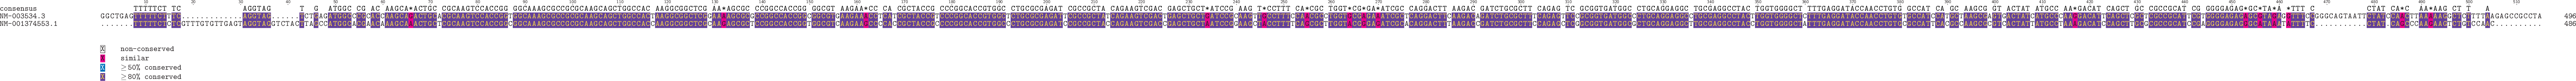

In [23]:
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

In [25]:
print(seq_records[0].seq.translate())
print(seq_records[1].seq.translate())

G*VFLSGSLRWPAPSRLHASPPVAKRRASSWPLRRLGKARRPPAA*RNLIATVPAPWLCARFAAIRSRLSC*SASCLSNAWCEKSLRTSRQICAFRVPR*WPCRRPARPTWWGSLRIPTCVPSMLSE*LSCPRTFSSLAAFVGRERRGFRAVILSNLKRLF*EPP
FFSRLC*VGRST*PWHEQSKLLASPPAAKRRASSWPPRRLARALRPPVASRSPTATAPAPWPCARSAATRSRPSC*SGSYLFSAWYGRSHRTLRPICASRARR*WRCRRLARPTWWGYLRIPTCAPFTPSASLLCLKTSSLRAASEGRGHKYFPISPRSLSN


In [27]:
translated_records = seq_records

'>NM_003534.3 Homo sapiens H3 clustered histone 8 (H3C8), mRNA\nGGCTGAGTTTTTCTTTCAGGTAGTCTGAGATGGCCCGCACCAAGCAGACTGCACGCAAGT\nCCACCGGTGGCAAAGCGCCGCGCAAGCAGCTGGCCACTAAGGCGGCTCGGAAAAGCGCGC\nCGGCCACCGGCGGCGTGAAGAAACCTCATCGCTACCGTCCCGGCACCGTGGCTCTGCGCG\nAGATTCGCCGCTATCAGAAGTCGACTGAGCTGCTGATCCGCAAGTTGCCTTTCCAACGCC\nTGGTGCGAGAAATCGCTCAGGACTTCAAGACAGATCTGCGCTTTCAGAGTTCCGCGGTGA\nTGGCCCTGCAGGAGGCCTGCGAGGCCTACTTGGTGGGGCTCTTTGAGGATACCAACCTGT\nGTGCCATCCATGCTAAGCGAGTGACTATCATGCCCAAGGACATTCAGCTCGCTCGCCGCA\nTTCGTGGGGAGAGAGCGTAGAGGTTTCCGGGCAGTAATTCTATCCAACTTAAAAAGGCTC\nTTTTAAGAGCCGCCTA\n'

In [40]:
translated_sequences = "\n".join(
    [
        SeqRecord(
            sr.seq.translate(),
            id=sr.id,
            name=sr.name,
            description=sr.description,
        ).format("fasta")
        for sr in seq_records
    ]
)
msa_translated = muscle_aln(translated_sequences)

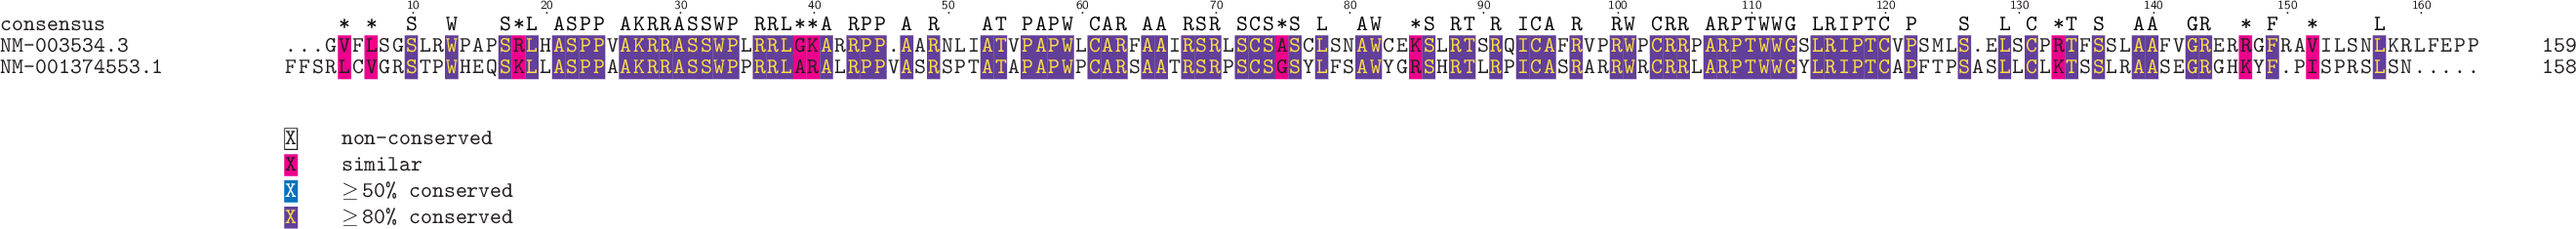

In [41]:
ipyshade.shadedmsa(
    msa_translated,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C1

In [45]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H3C1", "H3C8"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [50]:
print(sequences)

>XP_054541616.1|H3C1 H3C1|XP_054541616.1
MGVFALVLGIPLCCFAVMARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYR
PGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVG
LFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA

>XP_016810514.1|H3C8 H3C8|XP_016810514.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA



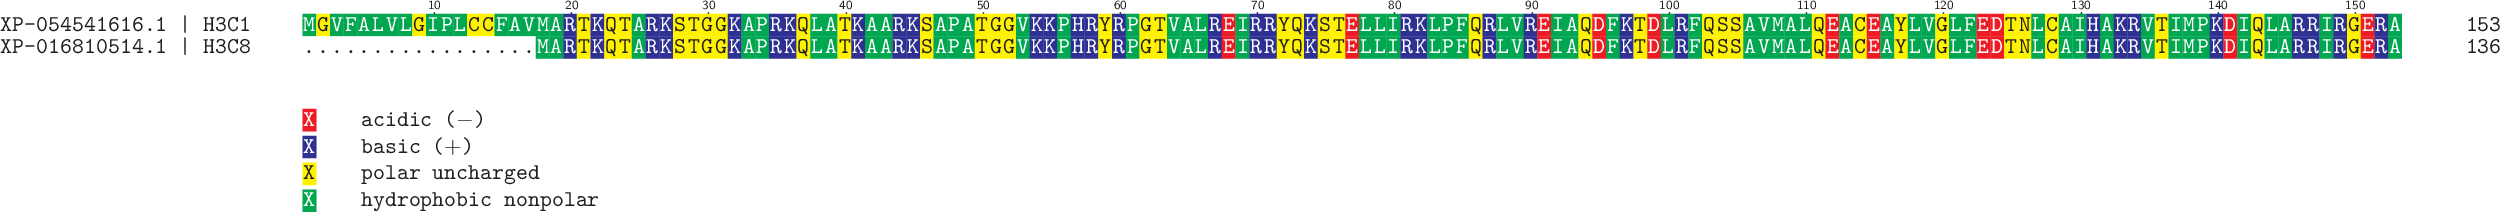

In [48]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["hydropathy_functional"],
    ruler=True,
    # logo=True,
)

# H2AC15

In [51]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2AC11", "H2AC15"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [52]:
print(sequences)

>XP_063668326.1|H2AC11 H2AC11|XP_063668326.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_054542624.1|H2AC15 H2AC15|XP_054542624.1
MSGRGKQGGKARTKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK



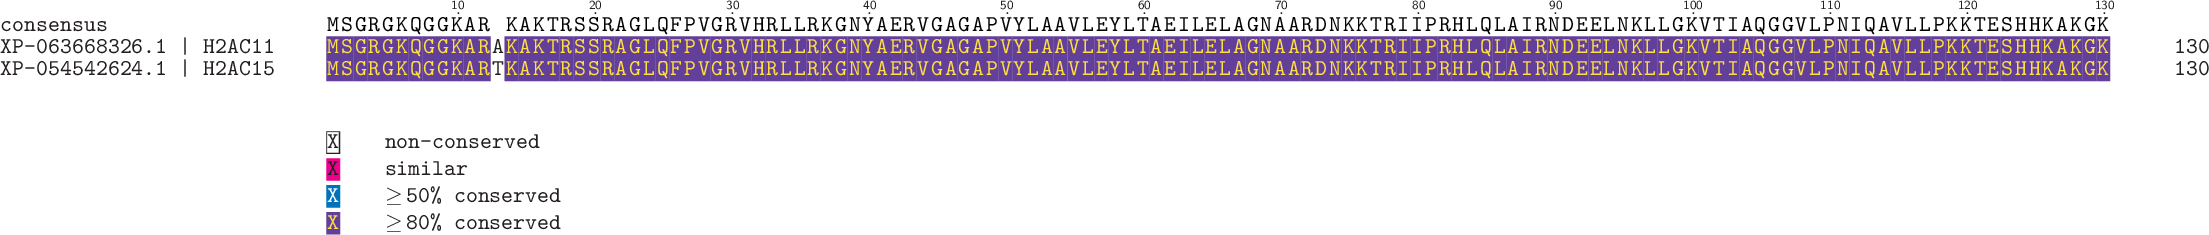

In [54]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# clustered H4

In [65]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[
            (df["Histone variant"] == "clustered H4") & (~df["sequence"].isna())
        ].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [63]:
print(sequences)

>XP_009428446.1|H4C1|isoform_1 H4C1|XP_009428446.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_009448973.3|H4C11|isoform_1 H4C11|XP_009448973.3
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>PNI76180.1|H4C13|isoform_1 H4C13|PNI76180.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYG

>XP_063653741.1|H4C14|isoform_1 H4C14|XP_063653741.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_063653739.1|H4C14|isoform_1 H4C14|XP_063653739.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_003308403.1|H4C14|isoform_1 H4C14|XP_003308403.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_063653754.1|H4C15|isoform_1 H4C15|XP_063653754.1
MSGRGK

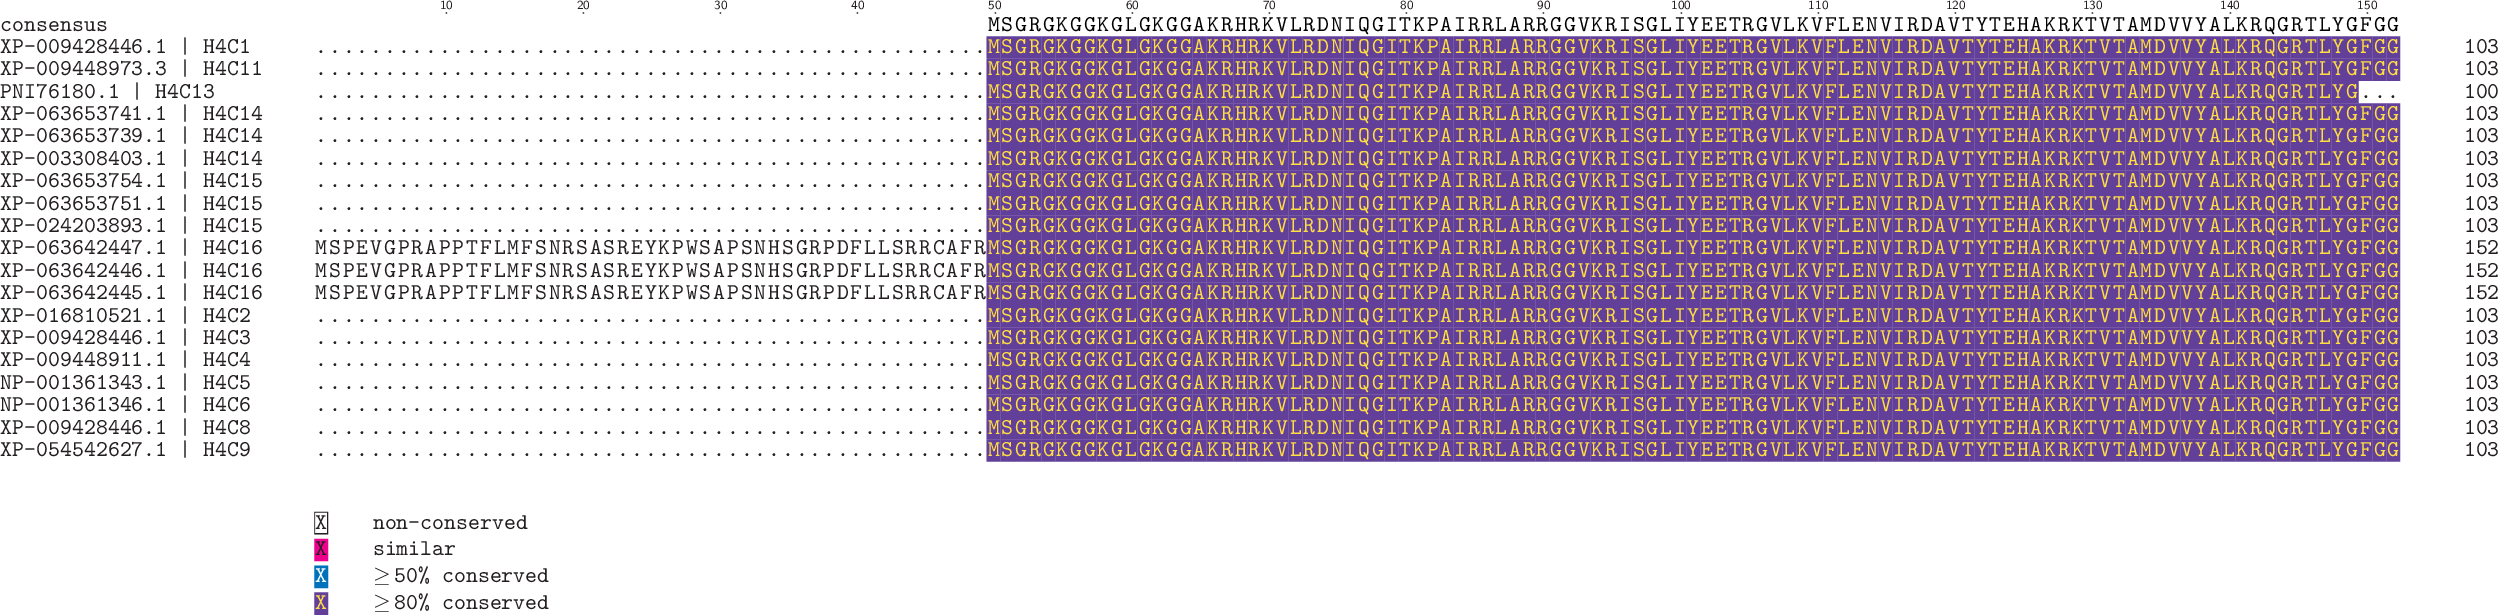

In [66]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

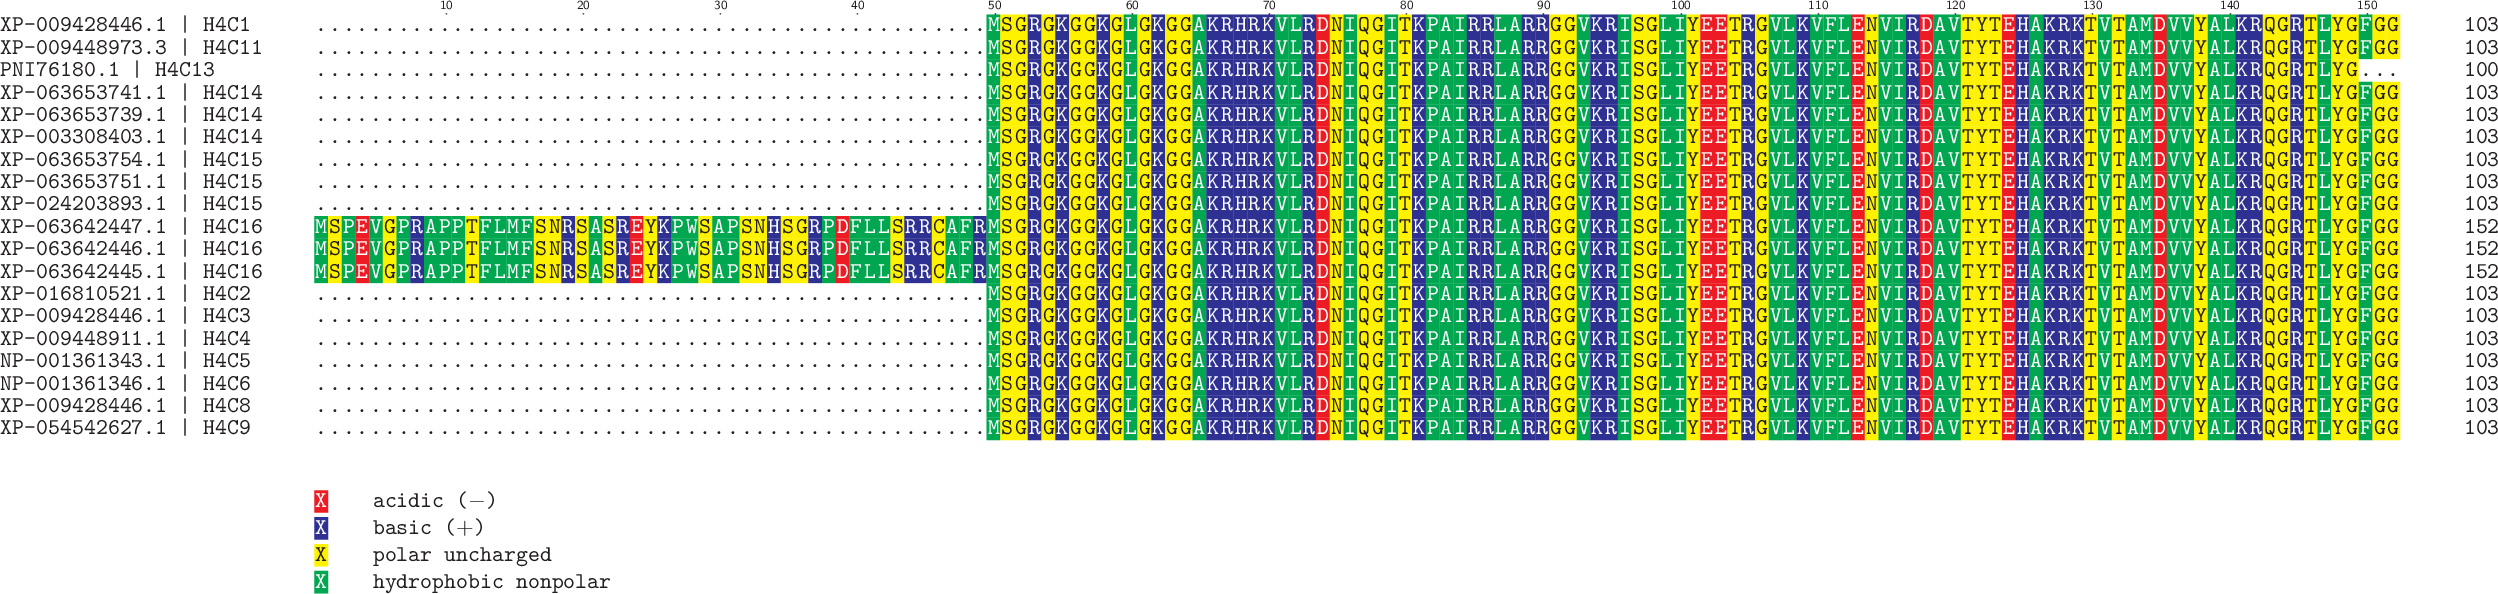

In [67]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["hydropathy_functional"],
    ruler=True,
    # logo=True,
)

# H2BC18 Macaque

In [12]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2BC18"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [13]:
print(sequences)

>XP_028685317.1|H2BC18 H2BC18|XP_028685317.1
MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSKSCSSKLIQCKRGSHGNPNLEIVGQKFWRPRLATGI

>XP_028685317.1|H2BC18 H2BC18|XP_028685317.1
MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSKSCSSKLIQCKRGSHGNPNLEIVGQKFWRPRLATGI

>XP_015006900.1|H2BC18 H2BC18|XP_015006900.1
MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSNIF

>XP_015006900.1|H2BC18 H2BC18|XP_015006900.1
MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSNIF



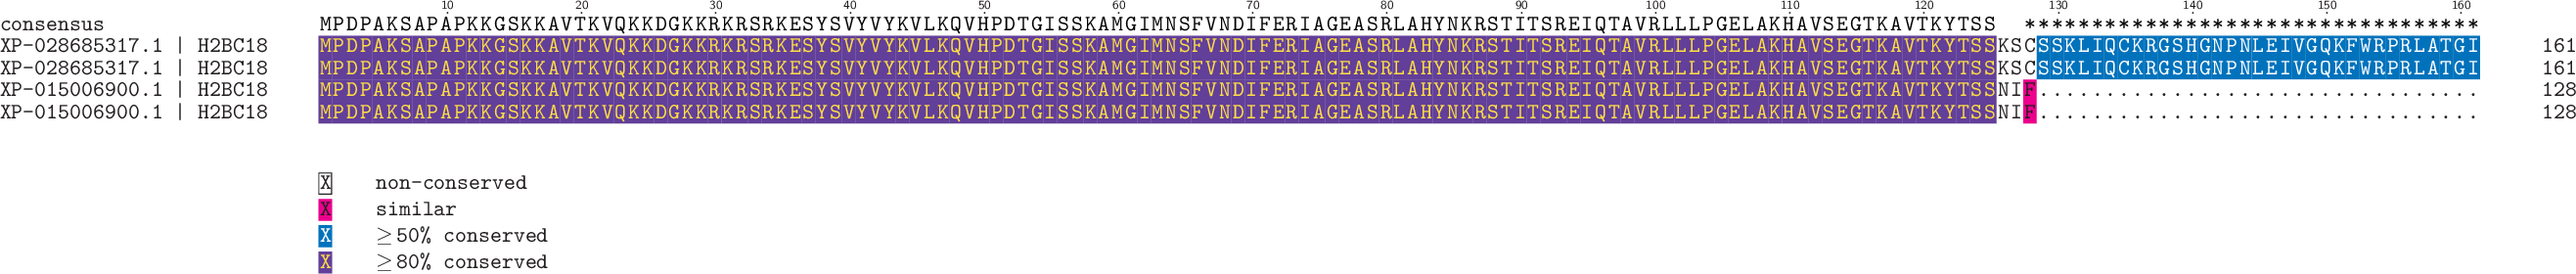

In [14]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC6 Macaque

In [15]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2BC8", "H2BC6"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [16]:
print(sequences)

>XP_001086637.2|H2BC6 H2BC6|XP_001086637.2
MRCRFHFDSYLQNSEGSMPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVY
KVLKQVHPDTGISSKAMGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLL
PGELAKHAVSEGTKAVTKYTSSK

>XP_001087459.1|H2BC8 H2BC8|XP_001087459.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK



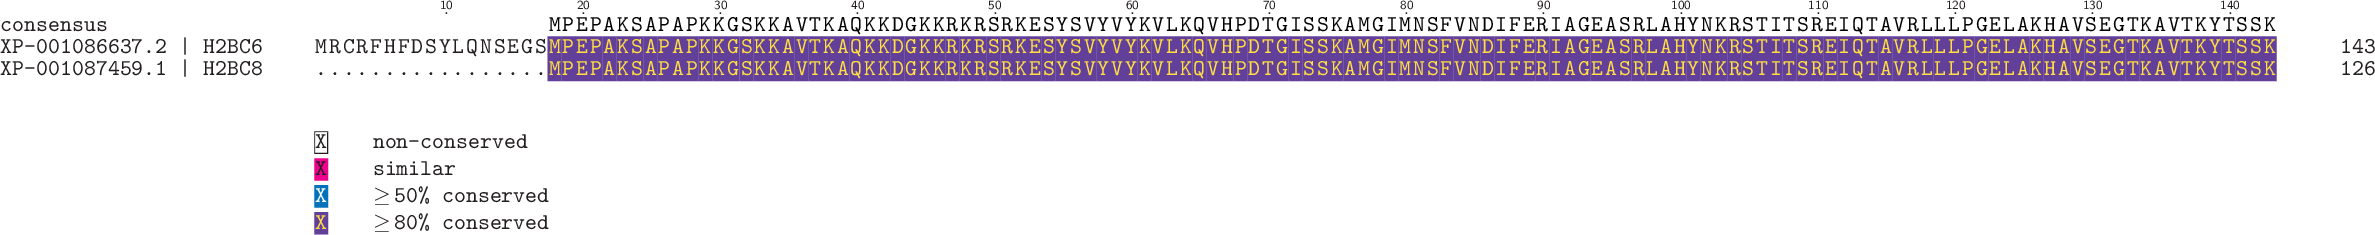

In [17]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC16 Macaque

In [18]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2AC11", "H2AC16"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [19]:
print(sequences)

>XP_014991239.1|H2AC11 H2AC11|XP_014991239.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_001096671.1|H2AC16 H2AC16|XP_001096671.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKSK



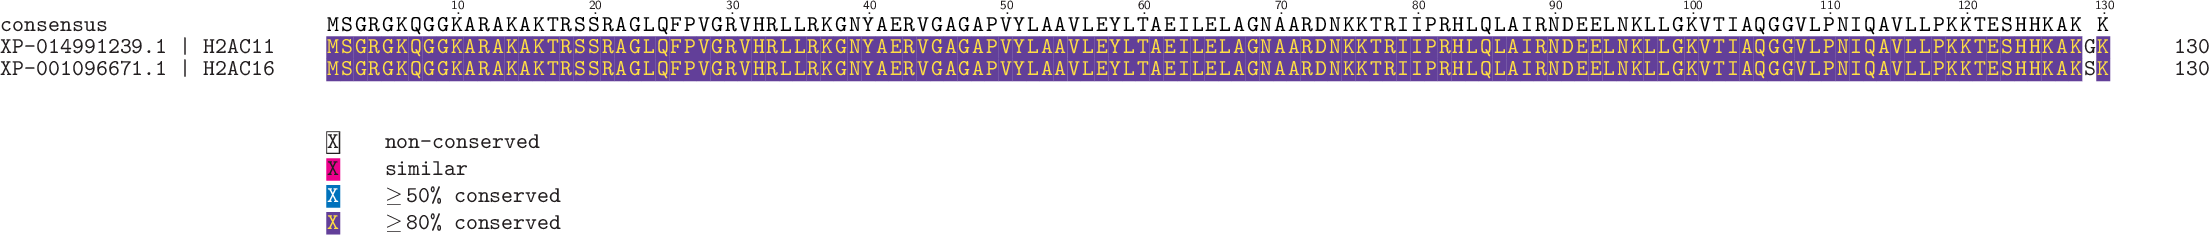

In [20]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H4C5 Macaque

In [21]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H4C1", "H4C5"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [22]:
print(sequences)

>XP_028703614.1|H4C1 H4C1|XP_028703614.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_028703613.1|H4C5 H4C5|XP_028703613.1
MCVFSLQLGPNSQHIRVLPLLVFQISPVGLSGWFGFAMSGRGKGGKGLGKGGAKRHRKVL
RDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVT
AMDVVYALKRQGRTLYGFGG



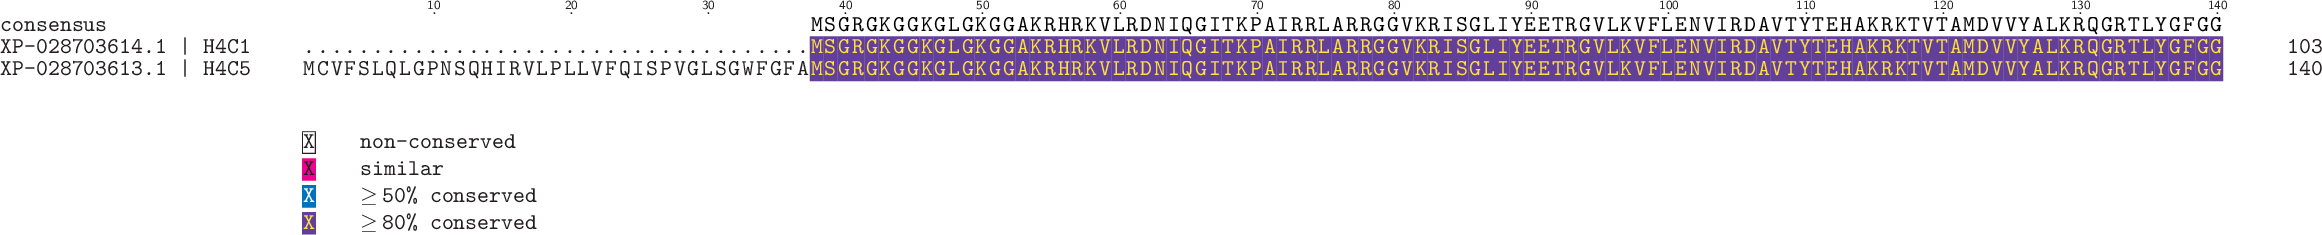

In [23]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C4 Dog

In [9]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H3C8", "H3C4"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [10]:
print(sequences)

>NP_001363857.2|H3C4 H3C4|NP_001363857.2
MGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRL
VREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTIMPKDIQLARRI
RGERA

>XP_038302065.1|H3C4 H3C4|XP_038302065.1
MGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRL
VREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCSGVVMSGRGKGGKGLGKGGA
KRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEH
AKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_038302064.1|H3C4 H3C4|XP_038302064.1
MGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRL
VREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTIMPKDIQLARRI
RGERA

>XP_038302063.1|H3C4 H3C4|XP_038302063.1
MGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRL
VREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTIMPKDIQLARRI
RGERA

>XP_038302062.1|H3C4 H3C4|XP_038302062.1
MGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRL
VREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTIMPKDIQLARRI
RGERA

>NP_001361514.1|H3C8 H3C8|NP_001361514.1
MARTKQTARKSTGGKAPRKQLATKAA

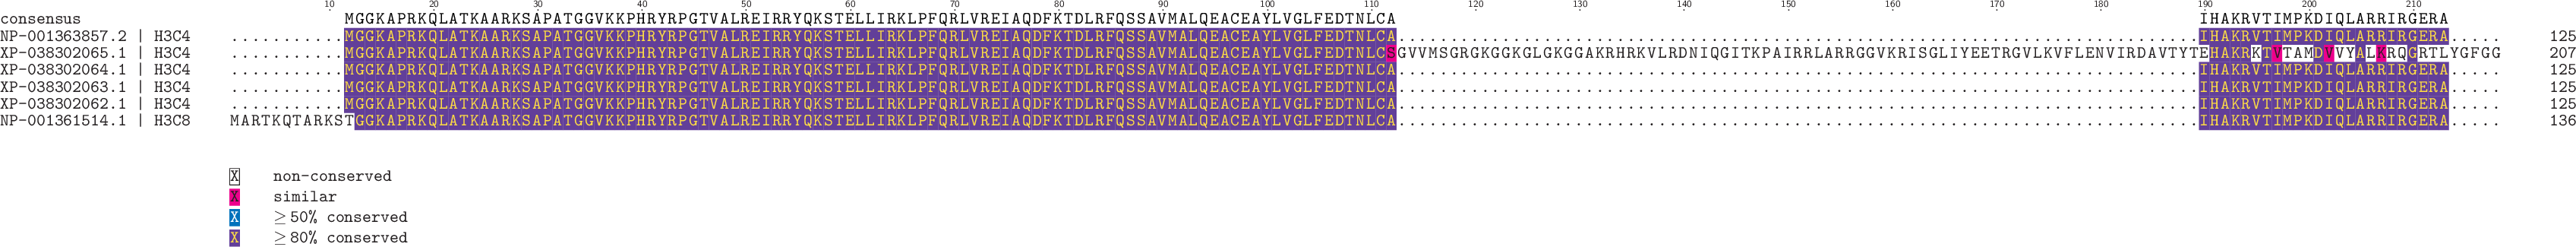

In [11]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C14 & H3C15 Dog

In [12]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H3C13", "H3C14", "H3C15"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [13]:
print(sequences)

>XP_038309091.1|H3C13 H3C13|XP_038309091.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_022260661.1|H3C13 H3C13|XP_022260661.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_013976105.1|H3C13 H3C13|XP_013976105.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_038417999.1|H3C13 H3C13|XP_038417999.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_038417998.1|H3C13 H3C13|XP_038417998.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_038417997.1|H3C13 H3C13|XP_038417997.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRY

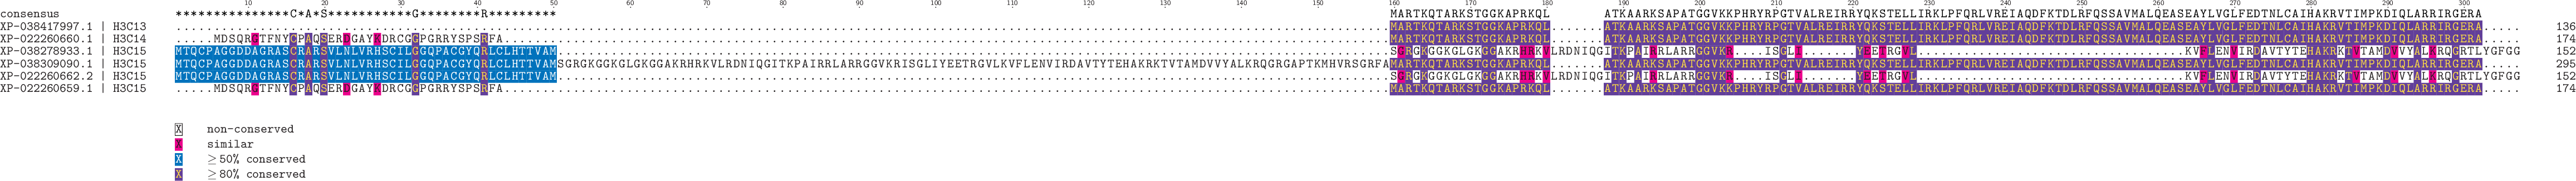

In [15]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa[5:],
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

In [16]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[
            df["accession"].isin(["XP_038309090.1", "XP_022260659.1"])
        ].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [17]:
print(sequences)

>XP_038309090.1|H3C15 H3C15|XP_038309090.1
MTQCPAGGDDAGRASCRARSVLNLVRHSCILGGQPACGYQRLCLHTTVAMSGRGKGGKGL
GKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAV
TYTEHAKRKTVTAMDVVYALKRQGRGAPTKMHVRSGRFAMARTKQTARKSTGGKAPRKQL
ATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKT
DLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA

>XP_022260659.1|H3C15 H3C15|XP_022260659.1
MDSQRGTFNYCPAQSERDGAYKDRCGGPGRRYSPSRFAMARTKQTARKSTGGKAPRKQLA
TKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTD
LRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA



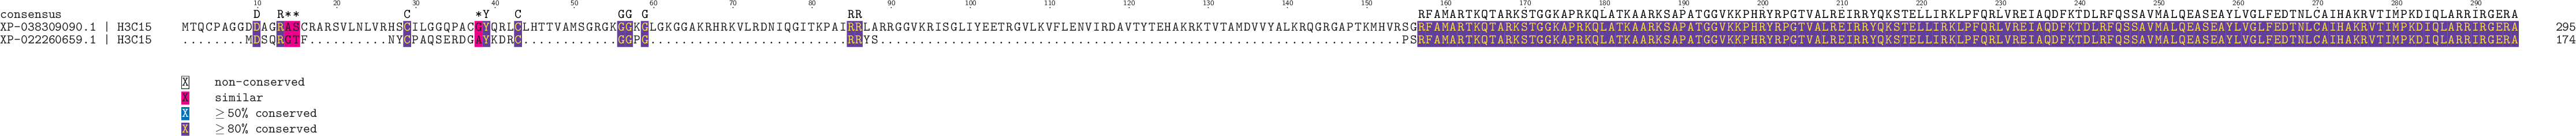

In [19]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC10 Dog

In [10]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2BC8", "H2BC10"])].head(4).iterrows()
        if row["accession"] != "XP_038440416.1"
    ]
)
msa = muscle_aln(sequences)

In [11]:
print(sequences)

>XP_038302547.1|H2BC10 H2BC10|XP_038302547.1
MGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAF
TKYTSFKQTPVQLRQRLQALLRATHMLT

>XP_005640223.2|H2BC10 H2BC10|XP_005640223.2
MGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAF
TKYTSFKQTPVQLRQRLQALLRATHMLI

>XP_038302478.1|H2BC8 H2BC8|XP_038302478.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK



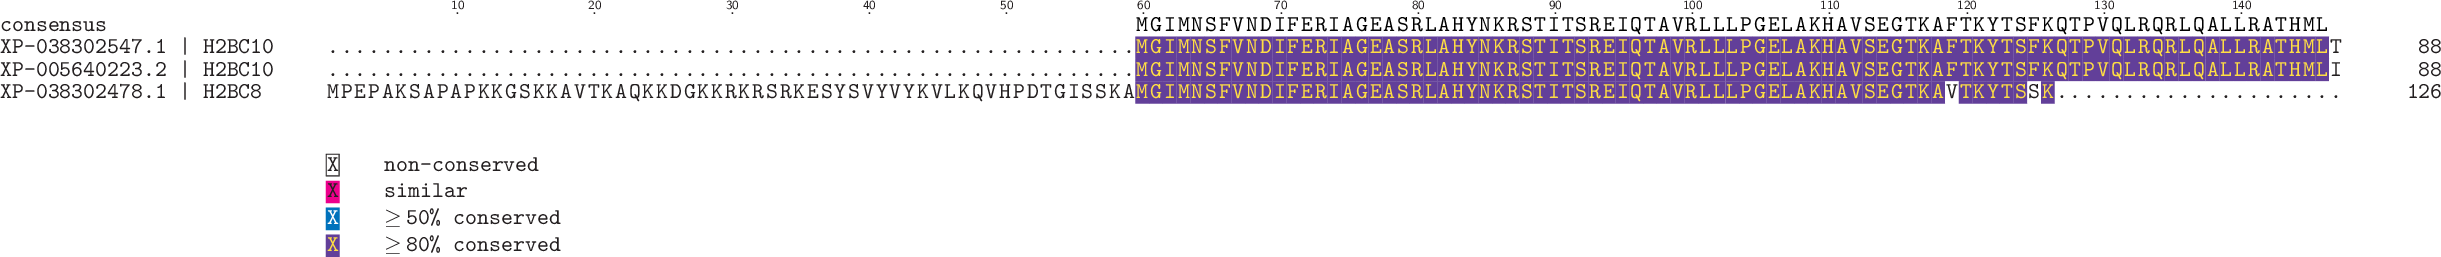

In [13]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC1 & H2BC2 Dog

In [10]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2BC1", "H2BC2"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [11]:
print(sequences)

>XP_038302443.1|H2BC1 H2BC1|XP_038302443.1
MPELTSKGTTISKKGFKRAVAKTQKKEGKKRRRCRKESYSIYIYKVLKQVHPDTGISSKA
MGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAV
TKYTSSK

>XP_545374.3|H2BC1 H2BC1|XP_545374.3
MPELTSKGTTISKKGFKRAVAKTQKKEGKKRRRCRKESYSIYIYKVLKQVHPDTGISSKA
MGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAV
TKYTSSK

>XP_038440238.1|H2BC1 H2BC1|XP_038440238.1
MPELTSKGTTISKKGFKRAVAKTQKKXGKKRRRCRKESYSIYIYKVLKQVHPDTGISSKA
MGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAV
TKYTSSK

>XP_038302444.1|H2BC2 H2BC2|XP_038302444.1
MPELTSKGTTISKKGFKRAVAKTQKKEGKKRRRCRKESYSIYIYKVLKQVHPDTGISSKA
MGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAV
TKYTSAK

>XP_022270208.1|H2BC2 H2BC2|XP_022270208.1
MPELTSKGTTISKKGFKRAVAKTQKKEGKKRRRCRKESYSIYIYKVLKQVHPDTGISSKA
MGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAV
TKYTSSK

>XP_038440244.1|H2BC2 H2BC2|XP_038440244.1
MPELTSKGTTISKKGFKRAVAKTQKKEGKKRRRCRKESYSIYIYKVLKQVHPDTGISSKA
MGIMNSFVNDIFERIAGEASRLAHYNKRSTIT

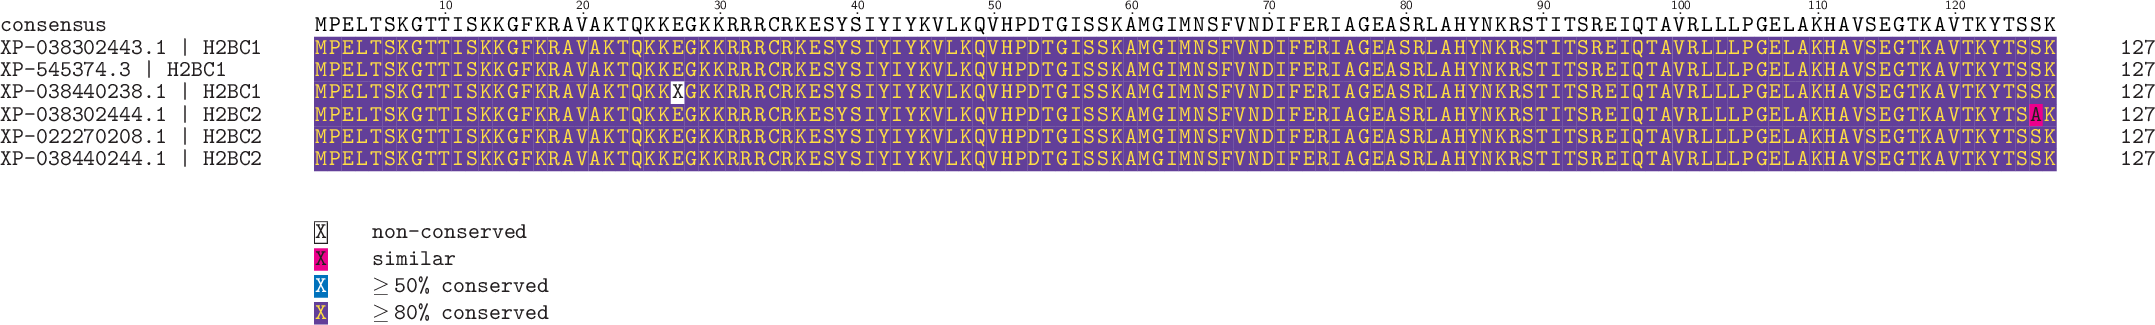

In [12]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC4-9, 13, 14, 17 Dog

In [13]:
curate_symbols = [f"H2BC{i}" for i in [4, 5, 6, 7, 8, 9, 13, 14, 17]]

In [14]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [15]:
print(sequences)

>XP_038302545.1|H2BC13 H2BC13|XP_038302545.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_854227.1|H2BC13 H2BC13|XP_854227.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_038440333.1|H2BC13 H2BC13|XP_038440333.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_038302544.1|H2BC14 H2BC14|XP_038302544.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_854244.1|H2BC14 H2BC14|XP_854244.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_038440354.1|H2BC14 H2BC14|XP_038440354.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTIT

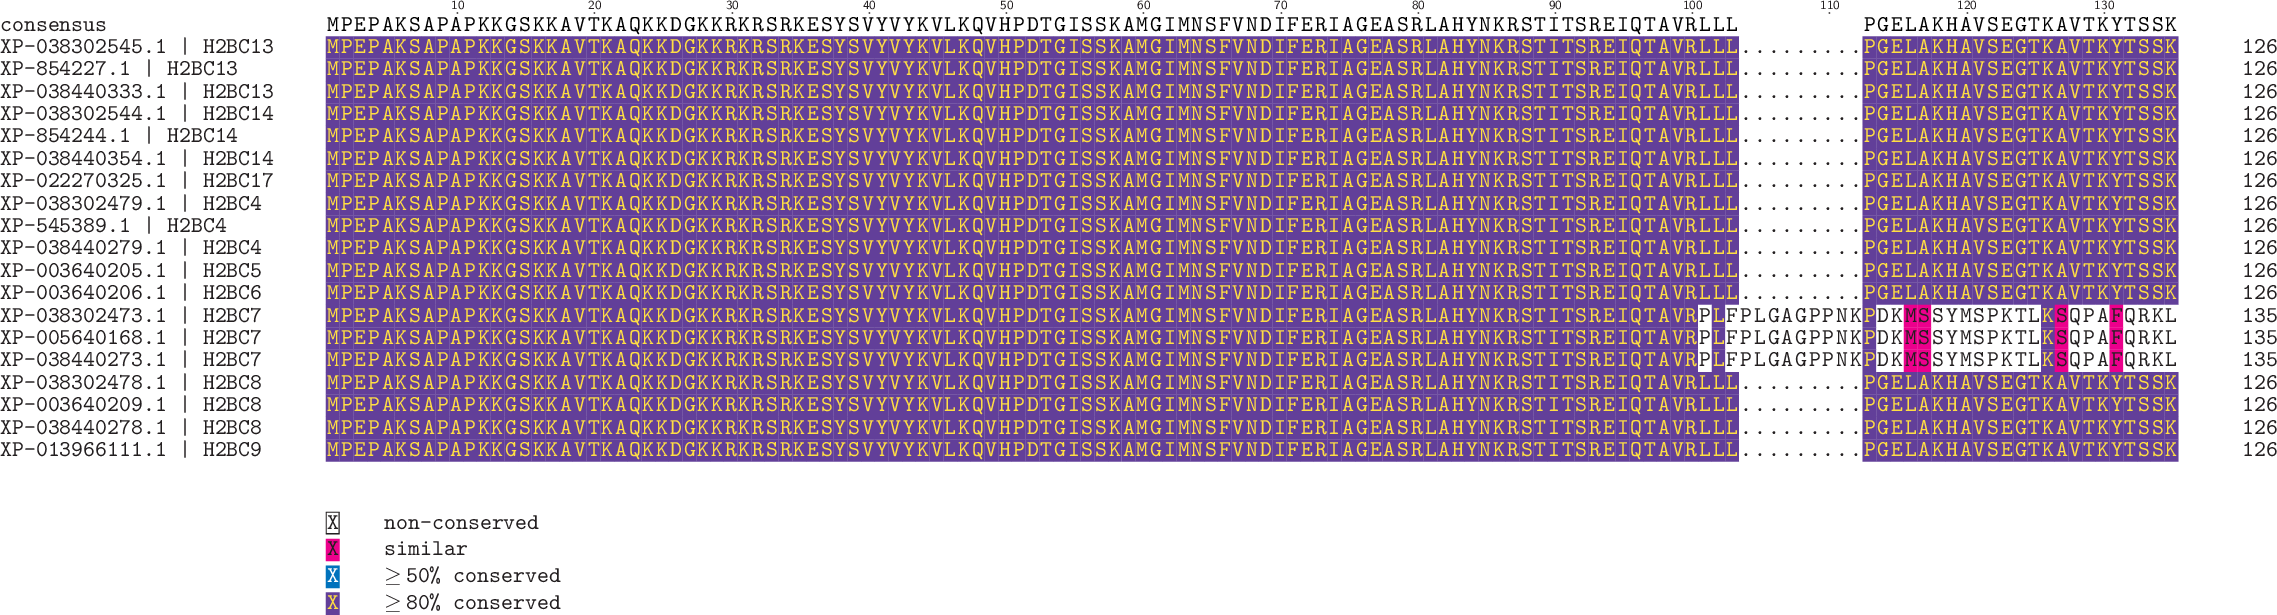

In [16]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC17 Dog

In [17]:
curate_symbols = [
    "H2AC11",
    "H2AC11",
    "H2AC11",
    "H2AC13",
    "H2AC13",
    "H2AC13",
    "H2AC15",
    "H2AC15",
    "H2AC15",
    "H2AC16",
    "H2AC16",
    "H2AC16",
    "H2AC17",
    "H2AC17",
    "H2AC17",
    "H2BC10",
]

In [18]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [19]:
print(sequences)

>XP_038302530.1|H2AC11 H2AC11|XP_038302530.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKSK

>XP_013965993.1|H2AC11 H2AC11|XP_013965993.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKSK

>XP_038440339.1|H2AC11 H2AC11|XP_038440339.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKSK

>XP_038302531.1|H2AC13 H2AC13|XP_038302531.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_022270322.1|H2AC13 H2AC13|XP_022270322.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_038440340.1|H2AC13 H2AC13|XP_038440340.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT

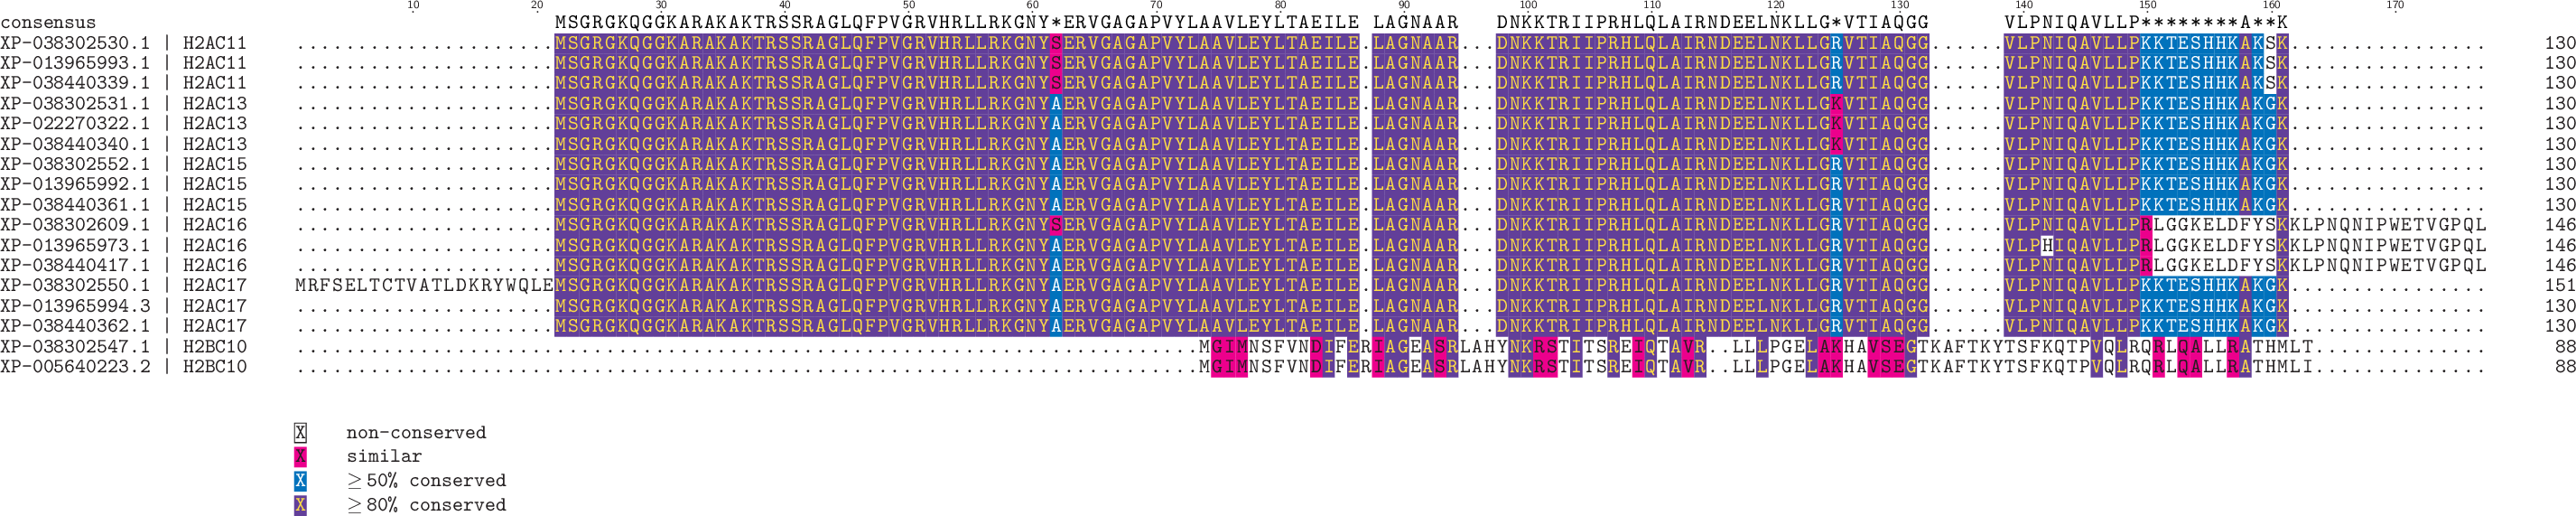

In [20]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC14 Dog

In [21]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2AC14"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [22]:
print(sequences)

>XP_038302527.1|H2AC14 H2AC14|XP_038302527.1
MRFSELTCTVATLDKRYWQLEMSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGN
YAERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLG
KVTIAQGGVLPNIQAVLLPKKTESHHKAK

>XP_022270324.1|H2AC14 H2AC14|XP_022270324.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAK

>XP_038440336.1|H2AC14 H2AC14|XP_038440336.1
MRFSELTCTVATLDKRYWQLEMSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGN
YAERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLG
KVTIAQGGVLPNIQAVLLPKKTESHHKAK



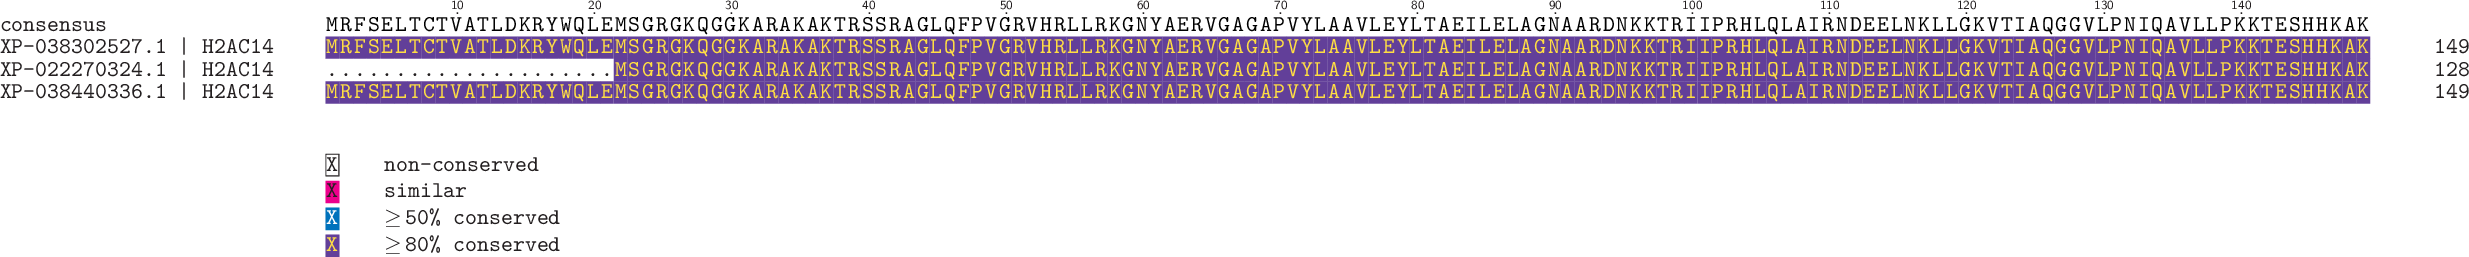

In [23]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC1 Dog

In [24]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2AC1"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [25]:
print(sequences)

>XP_038302442.1|H2AC1 H2AC1|XP_038302442.1
MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHHKVQSK

>XP_545373.2|H2AC1 H2AC1|XP_545373.2
MTSVQPQRYSSLVPALTAPLSRLRRVTERRSSVGRAVFIGTALQSASRCLGAGSKGGKAR
AKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLTAEILELAGNAAR
DNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKKTESHHHKVQSK

>XP_038440237.1|H2AC1 H2AC1|XP_038440237.1
MSGRGKQGGKARAKAKTRSSQGRACQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYL
TAEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPK
KTESHHHKVQSK



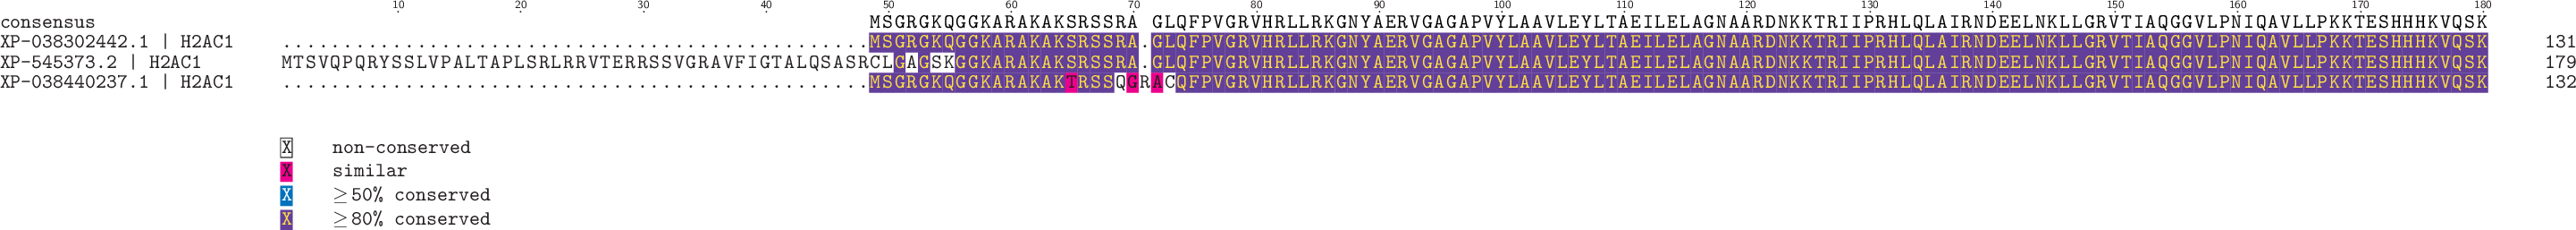

In [26]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC12 Dog

In [13]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H2AC12"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [14]:
print(sequences)

>XP_038318984.1|H2AC12 H2AC12|XP_038318984.1
MSGRGKQGGKARAKAKTRSSRAGLQFPILELAGNAARDNKKTRIIPRHLQLAIRNDEELN
KLLGRVTIAQGGVLPNIQAVLLPKKTESHHKAK

>XP_545413.1|H2AC12 H2AC12|XP_545413.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAK



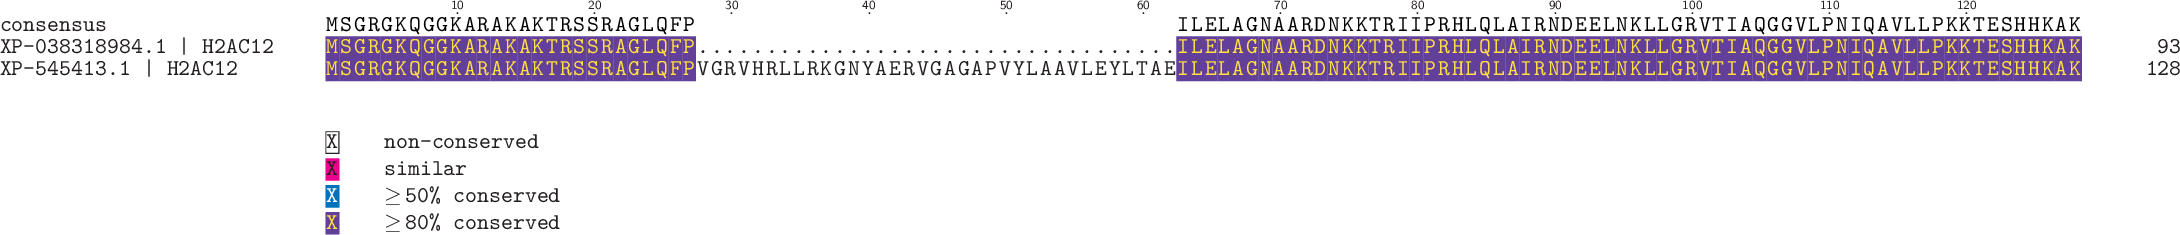

In [15]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC11, 13, 15, 16, 17 Dog

In [21]:
curate_symbols = [f"H2AC{i}" for i in [11, 13, 15, 16, 17]]

In [22]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [23]:
print(sequences)

>XP_038302530.1|H2AC11 H2AC11|XP_038302530.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKSK

>XP_013965993.1|H2AC11 H2AC11|XP_013965993.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKSK

>XP_038440339.1|H2AC11 H2AC11|XP_038440339.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKSK

>XP_038302531.1|H2AC13 H2AC13|XP_038302531.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_022270322.1|H2AC13 H2AC13|XP_022270322.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_038440340.1|H2AC13 H2AC13|XP_038440340.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT

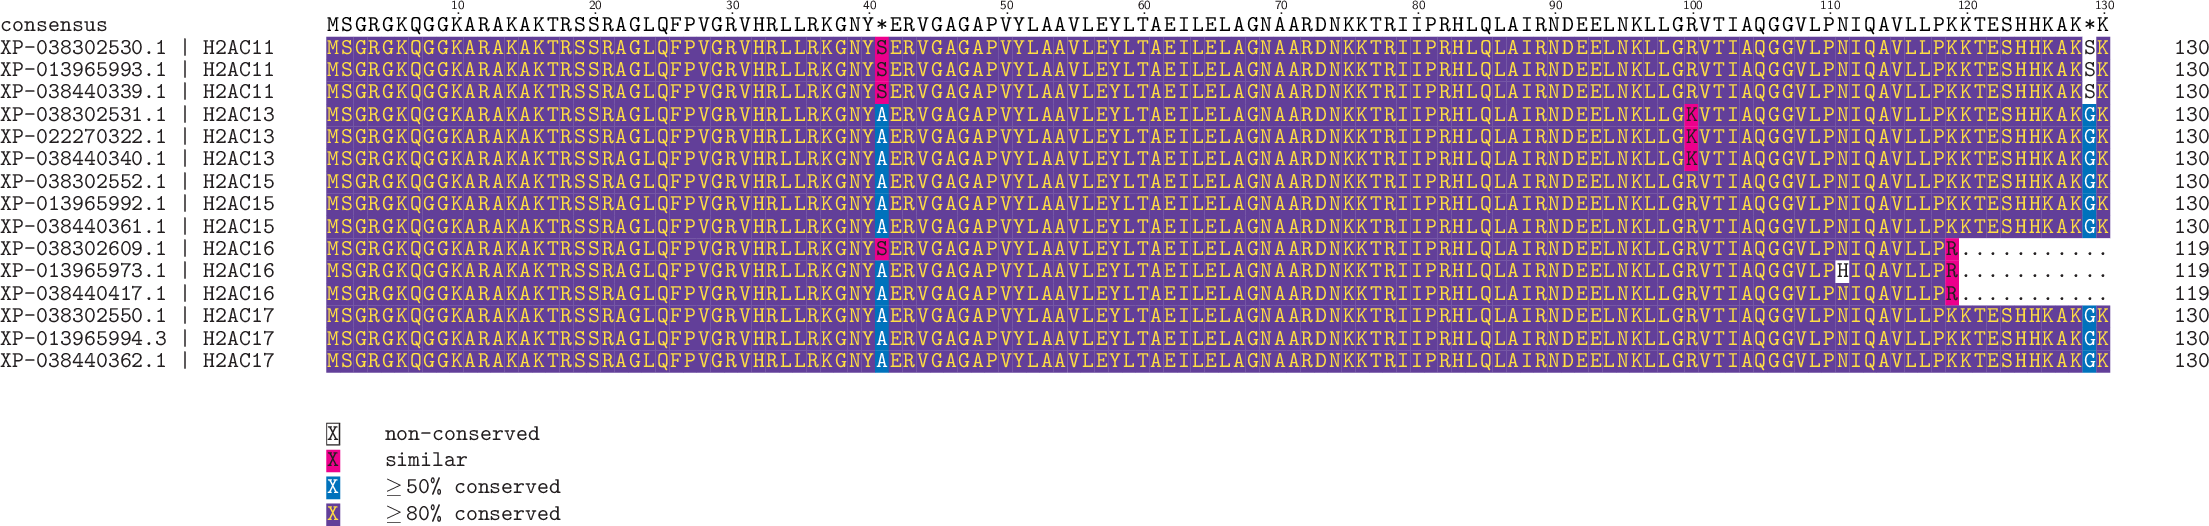

In [24]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC5, 7, 8, 15, 17 Dog

In [25]:
curate_symbols = [f"H2AC{i}" for i in [5, 7, 8, 15, 17]]

In [26]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [27]:
print(sequences)

>XP_038302552.1|H2AC15 H2AC15|XP_038302552.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_013965992.1|H2AC15 H2AC15|XP_013965992.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_038440361.1|H2AC15 H2AC15|XP_038440361.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_038302550.1|H2AC17 H2AC17|XP_038302550.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_013965994.3|H2AC17 H2AC17|XP_013965994.3
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_038440362.1|H2AC17 H2AC17|XP_038440362.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT

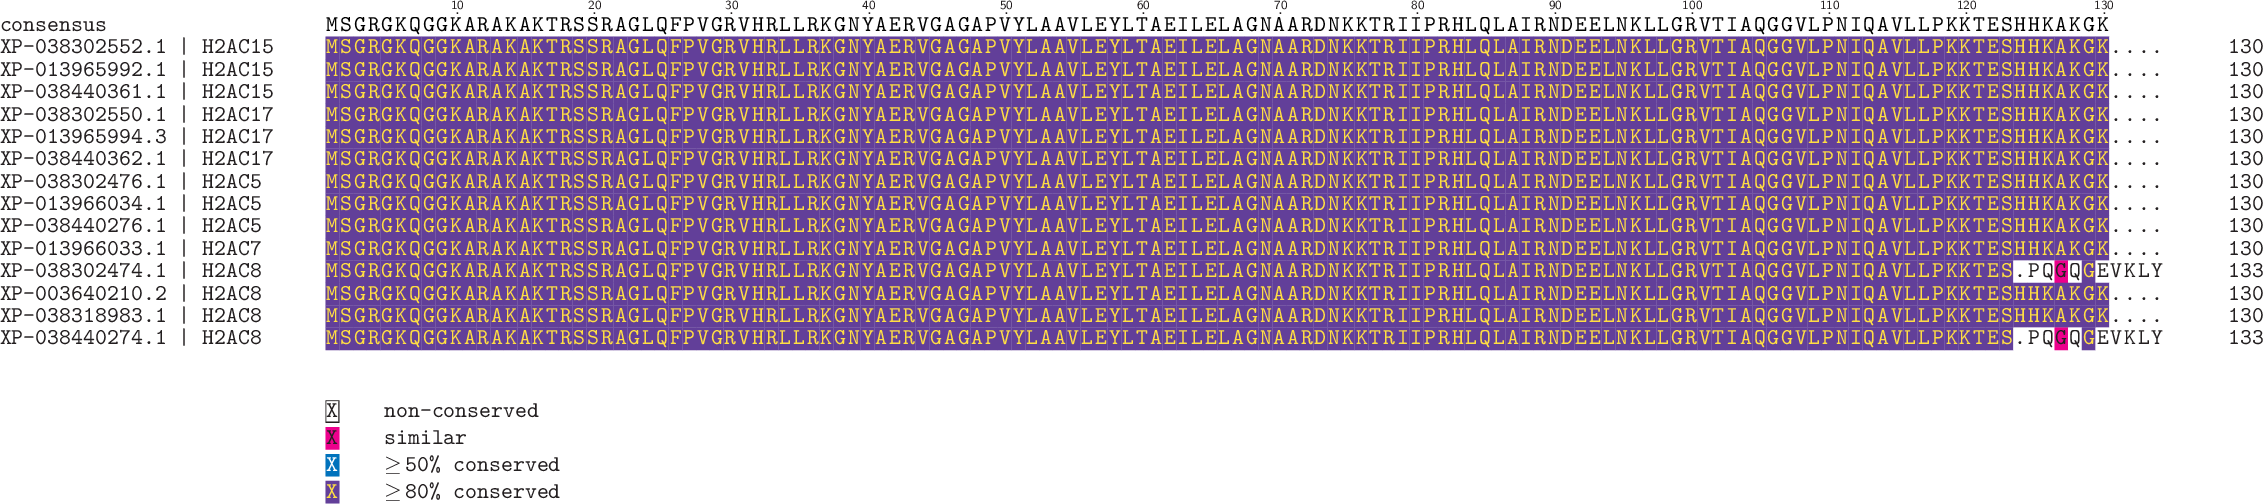

In [28]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC4, 8 Dog

In [29]:
curate_symbols = [f"H2AC{i}" for i in [4, 8]]

In [30]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [31]:
print(sequences)

>XP_038302477.1|H2AC4 H2AC4|XP_038302477.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_022270159.1|H2AC4 H2AC4|XP_022270159.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_038440277.1|H2AC4 H2AC4|XP_038440277.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_038302474.1|H2AC8 H2AC8|XP_038302474.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESPQGQGEVKLY

>XP_003640210.2|H2AC8 H2AC8|XP_003640210.2
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_038318983.1|H2AC8 H2AC8|XP_038318983.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAG

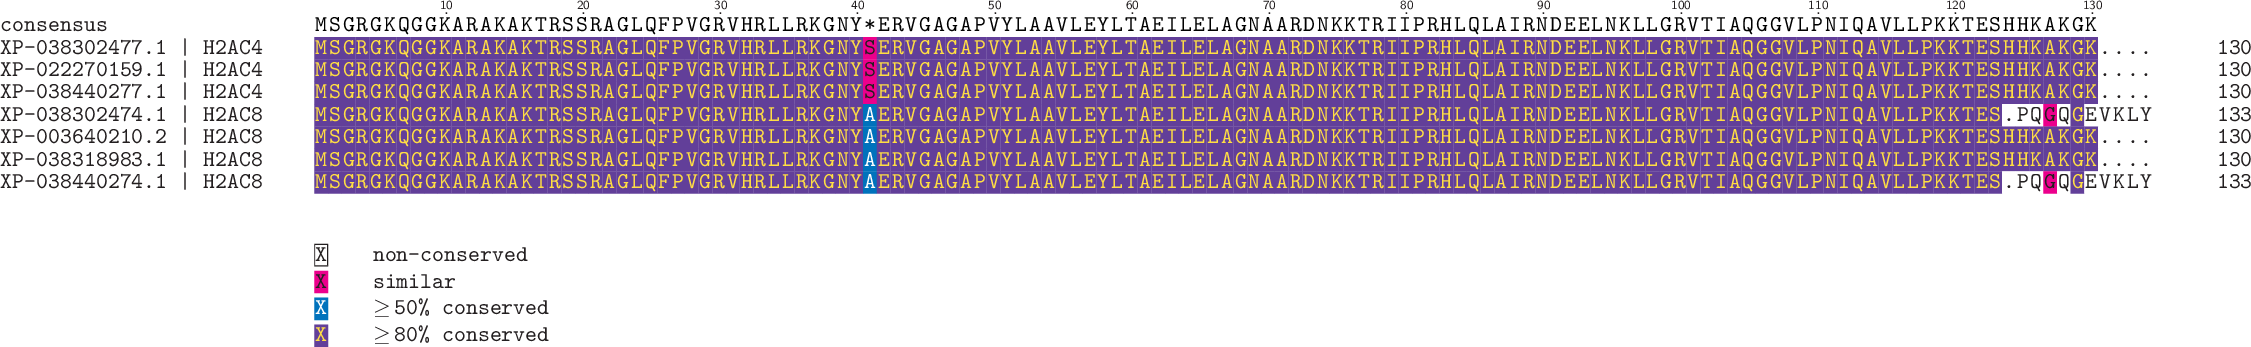

In [32]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H4 Dog

In [63]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].str.startswith("H4")].iterrows() if not isinstance(row["sequence"], float)
    ]
)
msa = muscle_aln(sequences)

In [64]:
print(sequences)

>XP_038302091.1|H4C11 H4C11|XP_038302091.1
MANRLFLEPSTLTKKAVPLLGFGHMTVNVYAQQLLLAQANVSLSSLGRGKGGKGLGKGGA
KRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEH
AKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_013966014.1|H4C11 H4C11|XP_013966014.1
MPLFGVVSVTVNVYAQQLLLAQANVSLSSLGRGKGGKGLGKGGAKRHRKVLRDNIQGITK
PAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALK
RQGRTLYGFGG

>XP_038439907.1|H4C11 H4C11|XP_038439907.1
MANRLFLEPSTLTKKAVPLLGFGHMTVNVYAQQLLLAQANVSLSSLGRGKGGKGLGKGGA
KRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEH
AKRKTVTAMDVVYALKRQGRTLYGFGG

>NP_001361520.1|H4C12 H4C12|NP_001361520.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>NP_001361518.1|H4C13 H4C13|NP_001361518.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_022260662.1|H4C14 H4C14|XP_022260662.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALK

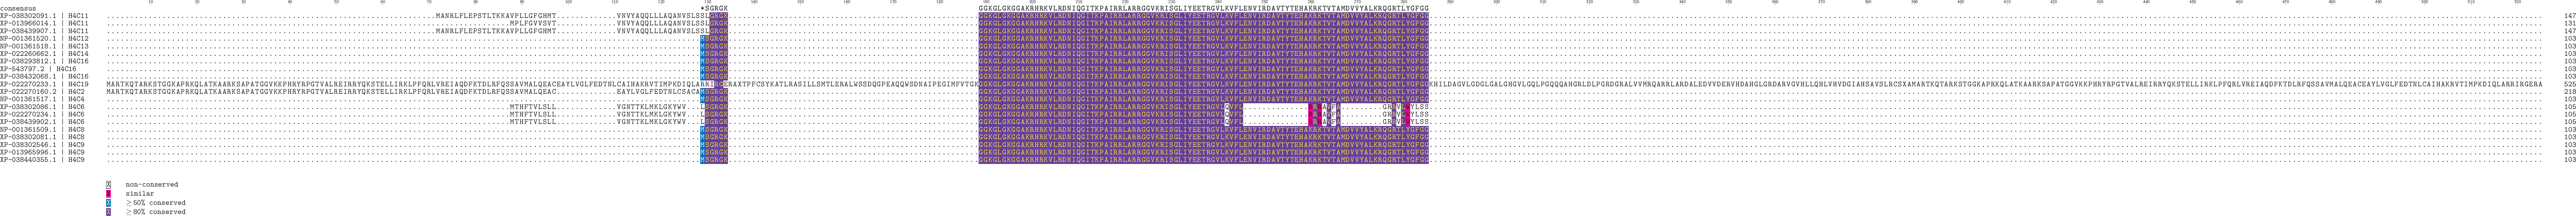

In [65]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H4C2 & H4C19 Dog

In [66]:
curate_symbols = [f"H4C{i}" for i in [2, 19]]

In [67]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [68]:
print(sequences)

>XP_022270233.1|H4C19 H4C19|XP_022270233.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERAXTPFCSYKATLRASILLSMTLERALWSSDQGPEAQQWSDNAIPE
GIMFVTGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGV
LKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGGKHILDAGVLGDGLGA
LGHGVLGQLPGQQQAHGRLDLPGRDGRALVVMRQARRLARDALEDVVDERVHDAHGLGRD
ARVGVHLLQHLVHVDGIAHSAVSLRCSXAMARTKQTARKSTGGKAPRKQLATKAARKSAP
ATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVM
ALQEACEAYLVGLFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA

>XP_022270160.2|H4C2 H4C2|XP_022270160.2
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCSACAMSGRG
KGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLEN
VIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG



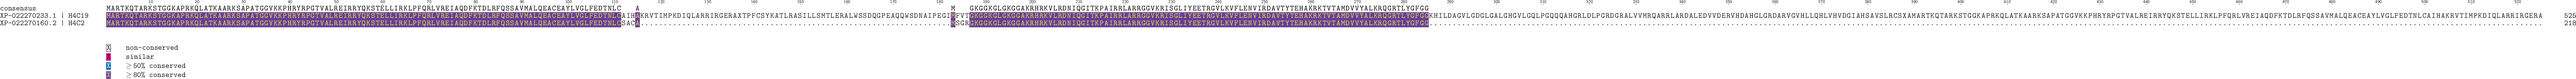

In [69]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC8, 4, 6, 7 Cattle

In [74]:
curate_symbols = [f"H2BC{i}" for i in [8, 4, 6, 7]]

In [75]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [76]:
print(sequences)

>XP_059736716.1|H2BC4 H2BC4|XP_059736716.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_010816816.1|H2BC6 H2BC6|XP_010816816.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_002697561.1|H2BC7 H2BC7|XP_002697561.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>NP_001099113.1|H2BC8 H2BC8|NP_001099113.1
MGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAV
TKYTSSK



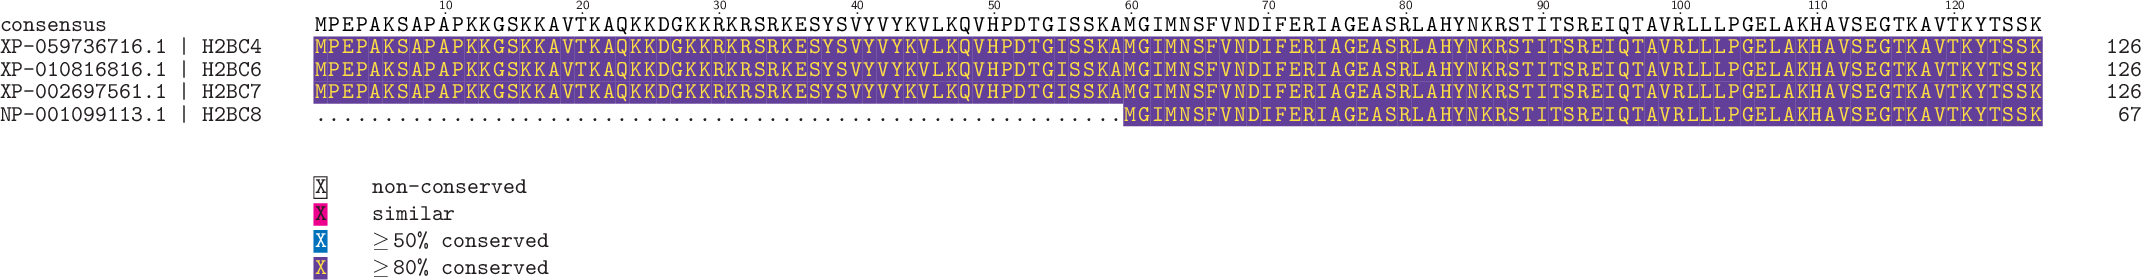

In [77]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC8, 4, 6, 7 Cattle after correction

In [80]:
curate_symbols = [f"H2BC{i}" for i in [8, 4, 6, 7]]

In [81]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [82]:
print(sequences)

>XP_059736716.1|H2BC4 H2BC4|XP_059736716.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_010816816.1|H2BC6 H2BC6|XP_010816816.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_002697561.1|H2BC7 H2BC7|XP_002697561.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>NP_001099113.1|H2BC8 H2BC8|NP_001099113.1
MPEPAKSAPAPKKGSKKAVTKAQKKDG*KRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK



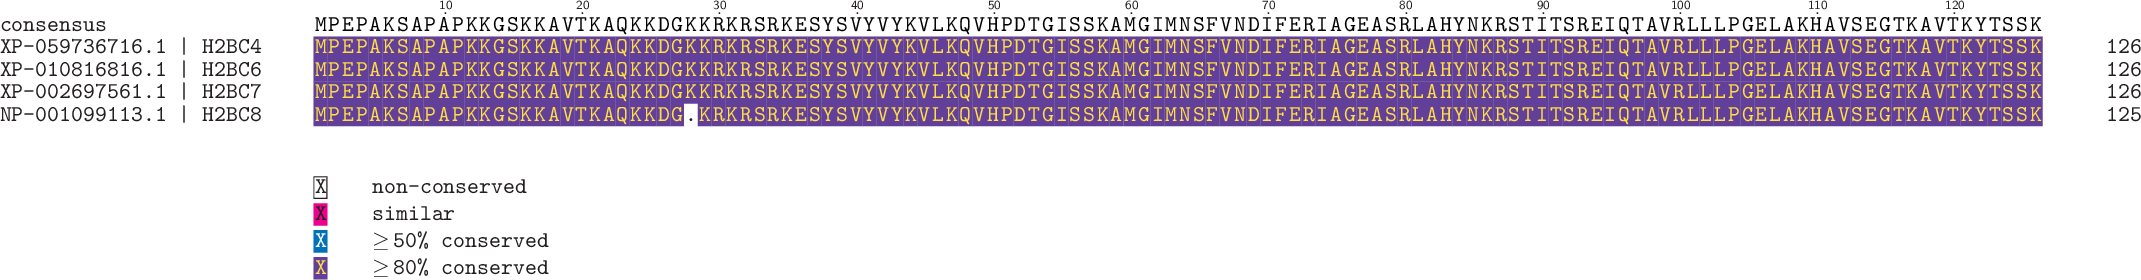

In [83]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC8, 4, 6, 7 Cattle after correction

In [85]:
curate_symbols = [f"H2BC{i}" for i in [8, 4, 6, 7]]

In [86]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [87]:
print(sequences)

>XP_059736716.1|H2BC4 H2BC4|XP_059736716.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_010816816.1|H2BC6 H2BC6|XP_010816816.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_002697561.1|H2BC7 H2BC7|XP_002697561.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>NP_001099113.1|H2BC8 H2BC8|NP_001099113.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
PEPAKSAPAPKKGSKKAVTKAQKKDG*KRKRSRKESYSVYVYKVLKQVHPDTGISSKAMG
IMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVTK
YTSSK



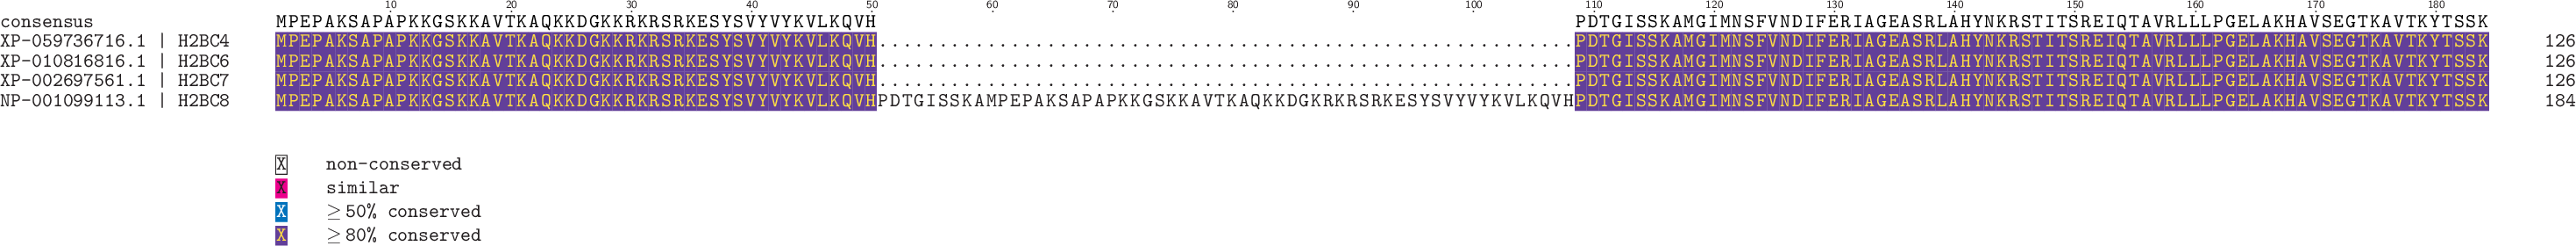

In [88]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC13, 14, 16, 17, 19, 20, 4, 6, 7, 8, 9 Cattle

In [11]:
curate_symbols = [f"H2BC{i}" for i in [13, 14, 16, 17, 19, 20, 4, 6, 7, 8, 9]]

In [12]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [13]:
print(sequences)

>XP_024839708.1|H2BC13 H2BC13|XP_024839708.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_024839707.1|H2BC14 H2BC14|XP_024839707.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_059736717.1|H2BC16 H2BC16|XP_059736717.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_015315427.1|H2BC17 H2BC17|XP_015315427.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>NP_001032546.1|H2BC19 H2BC19|NP_001032546.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_024845743.1|H2BC20 H2BC20|XP_024845743.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEAS

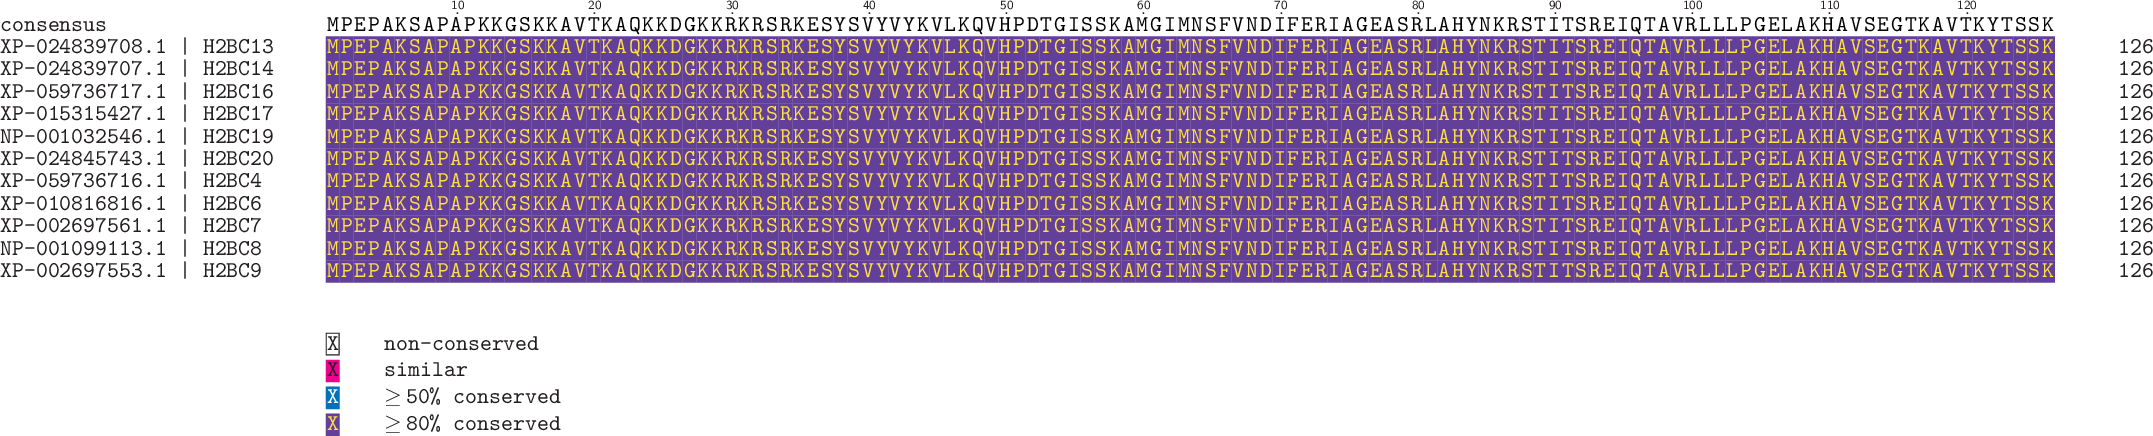

In [14]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC11, 16, 17, 13, 15 Cattle

In [15]:
curate_symbols = [f"H2AC{i}" for i in [11, 16, 17, 13, 15]]

In [16]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [17]:
print(sequences)

>XP_059736715.1|H2AC11 H2AC11|XP_059736715.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_010816748.1|H2AC13 H2AC13|XP_010816748.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKTK

>XP_003587761.1|H2AC15 H2AC15|XP_003587761.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_005223785.1|H2AC16 H2AC16|XP_005223785.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_010816763.1|H2AC17 H2AC17|XP_010816763.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK



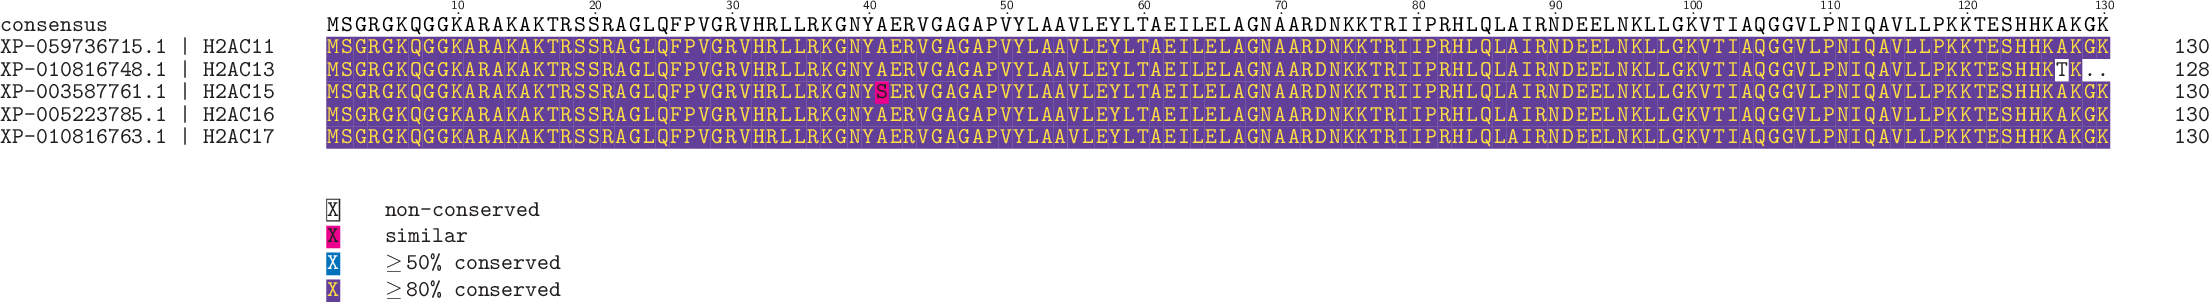

In [18]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC4 & H2AC8 Cattle

In [19]:
curate_symbols = [f"H2AC{i}" for i in [4, 8]]

In [20]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [21]:
print(sequences)

>XP_010816817.1|H2AC4 H2AC4|XP_010816817.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_015315464.1|H2AC8 H2AC8|XP_015315464.1
MSGRGKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK



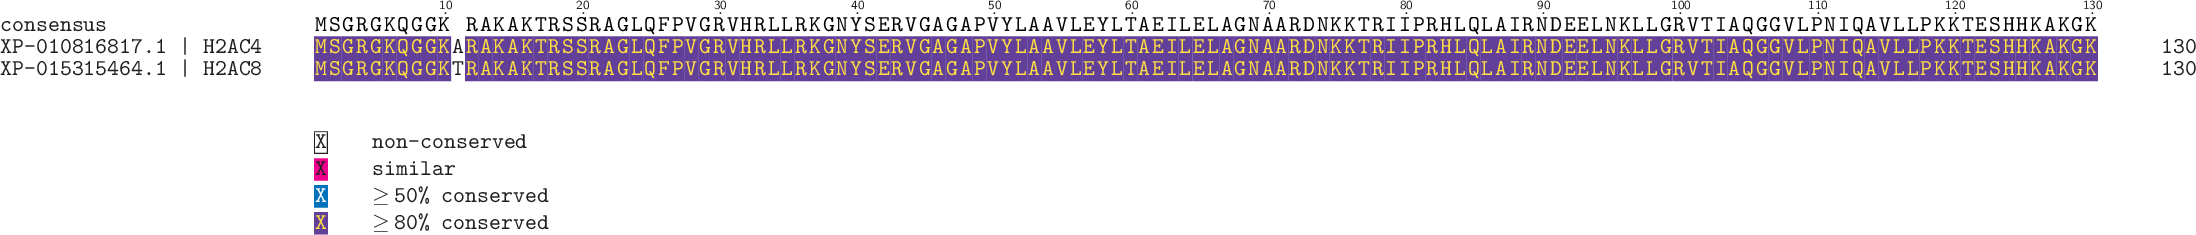

In [22]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H4C4 & H4C1 Cattle

In [23]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H4C4", "H4C1"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [24]:
print(sequences)

>NP_001361457.1|H4C1 H4C1|NP_001361457.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>NP_001093194.1|H4C4 H4C4|NP_001093194.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEEARGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG



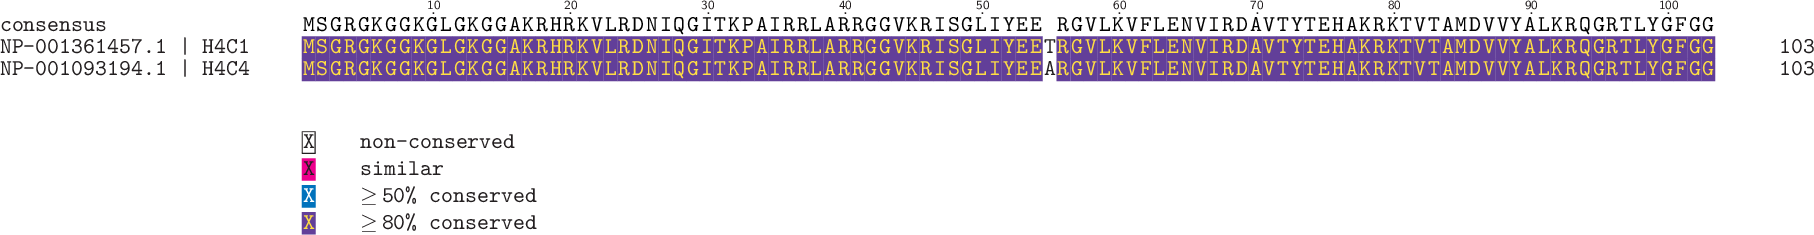

In [25]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H4C7 & H4C1 Cattle

In [26]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H4C7", "H4C1"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [27]:
print(sequences)

>NP_001361457.1|H4C1 H4C1|NP_001361457.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>NP_001361466.1|H4C7 H4C7|NP_001361466.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG



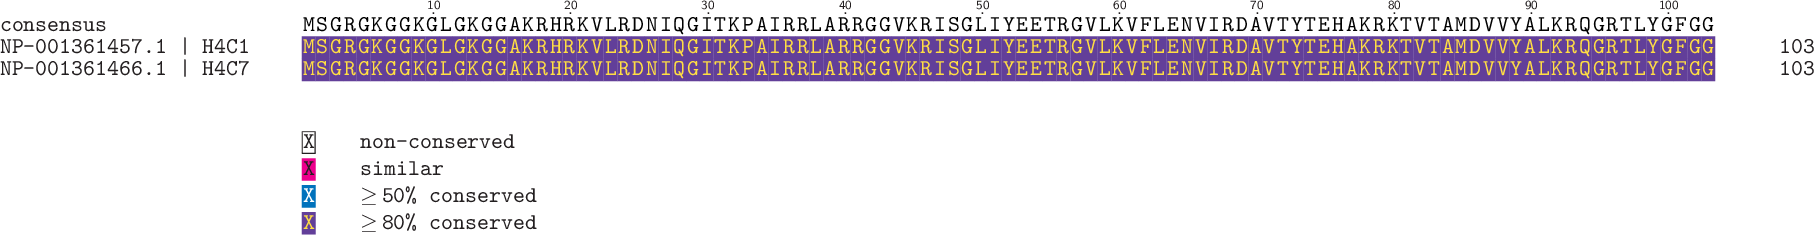

In [28]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC4, 10, 8, 6 Pig

In [36]:
curate_symbols = [f"H2BC{i}" for i in [4, 10, 8, 6]]

In [42]:
curate_symbols = [f"H2BC{i}" for i in [10, 8, 6]]

In [43]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [44]:
print(sequences)

>XP_020955495.1|H2BC10 H2BC10|XP_020955495.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_001927974.2|H2BC6 H2BC6|XP_001927974.2
MPEPTKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRXTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_001927752.1|H2BC8 H2BC8|XP_001927752.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK



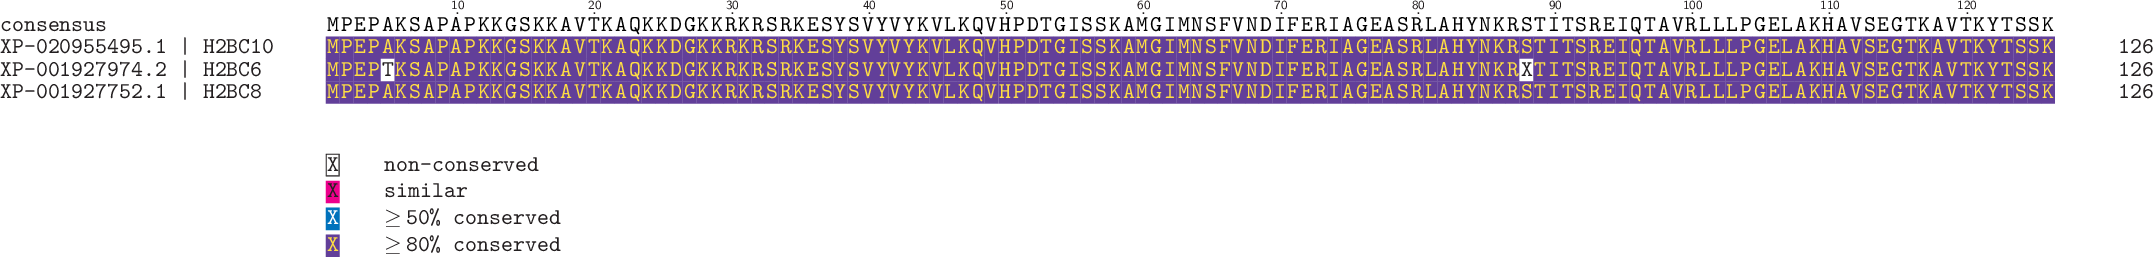

In [45]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC12, 13, 11, 17, 15, 16 Pig

In [50]:
curate_symbols = [f"H2AC{i}" for i in [12, 13, 11, 17, 15, 16]]

In [51]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [52]:
print(sequences)

>XP_020955498.1|H2AC11 H2AC11|XP_020955498.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_020955499.1|H2AC12 H2AC12|XP_020955499.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAK

>XP_001928592.1|H2AC13 H2AC13|XP_001928592.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAK

>XP_013832958.1|H2AC15 H2AC15|XP_013832958.1
MSGRGKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKPKGK

>nan|H2AC16 H2AC16|nan
VFLFSLQSLLCQFPIADHVWTWEAGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAER
VGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTI
AQGGVLPNIQAVLLPKKTESHHKAKGNRGFLHRRRGSRLSRSGFRHGDGRNCQRK

>XP_003356618.1|H2AC17 H2AC17|XP_003356618.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYA

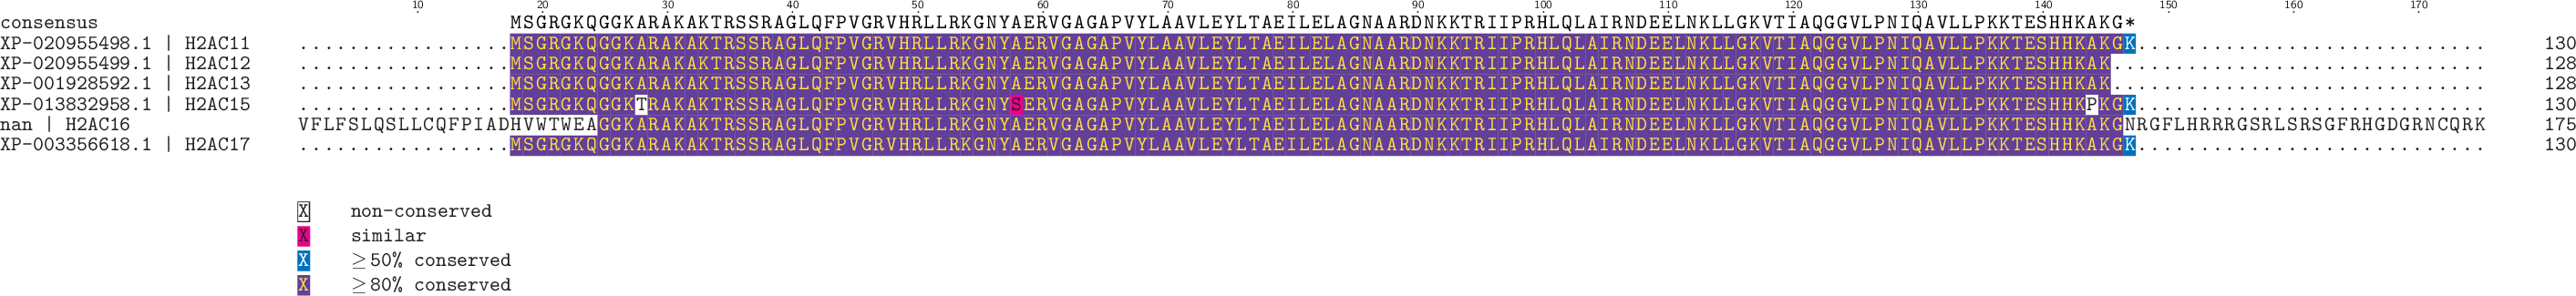

In [53]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H4C14 & H4C11 Pig

In [54]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=row["accession"],
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(["H4C14", "H4C11"])].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [55]:
print(sequences)

>XP_005665718.2|H4C11 H4C11|XP_005665718.2
MSGRGKGGKGXGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>XP_020945589.1|H4C14 H4C14|XP_020945589.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG



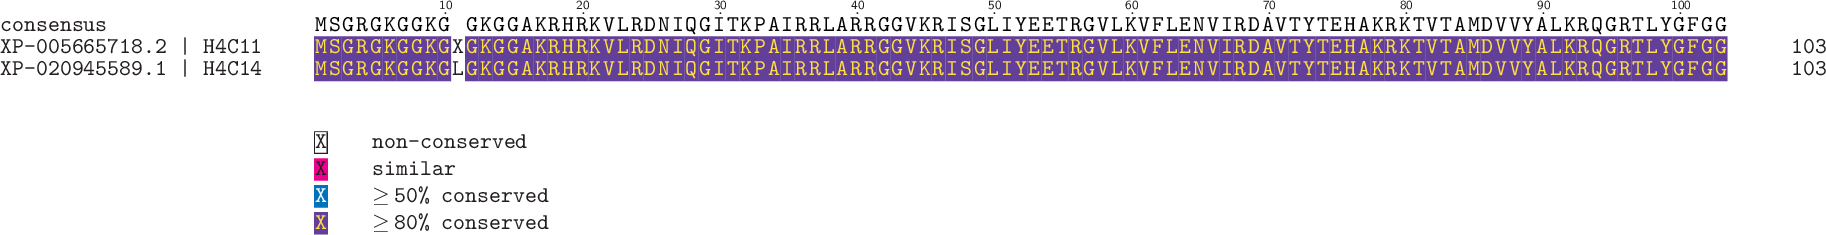

In [56]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C10, 1, 4 Pig

In [57]:
curate_symbols = [f"H3C{i}" for i in [10, 1, 4]]

In [58]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [59]:
print(sequences)

>nan|H3C1 H3C1|nan
MYVCQALDIMFRKAPGVKVWPVLSKPLVNLPAARRRVSSWLQGCRKSAPATGGVKKPHRY
RPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLV
GLFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA

>nan|H3C10 H3C10|nan
MIETIRGYRKQQIKFRVLFSPVTGWPHRYWPGTVALREIRRYQKSTELLIRKLPFQRLVR
EIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTIMPKDIQLARRIRG
ERA

>NP_001274345.1|H3C4 H3C4|NP_001274345.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA



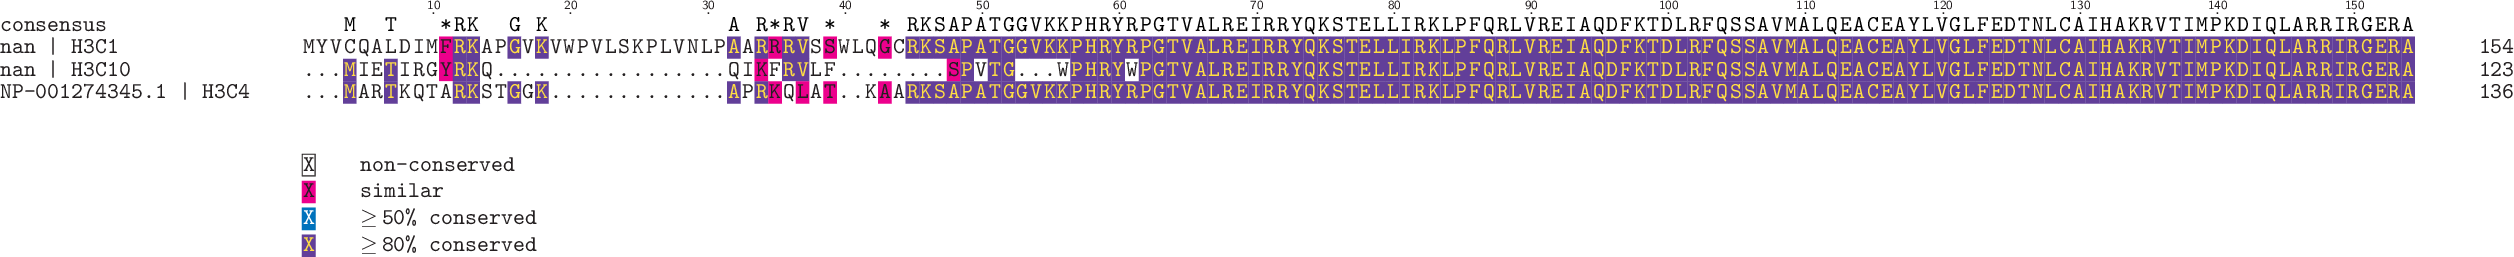

In [60]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2BC13, 14, 4, 6, 8, 10, 7 Horse

In [65]:
curate_symbols = [f"H2BC{i}" for i in [13, 14, 4, 6, 8, 10, 7]]

In [66]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [67]:
print(sequences)

>XP_001498394.1|H2BC10 H2BC10|XP_001498394.1
MPEPAKSAPVPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_023479919.2|H2BC13 H2BC13|XP_023479919.2
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>nan|H2BC14 H2BC14|nan
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>NP_001422711.1|H2BC4 H2BC4|NP_001422711.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_070100270.1|H2BC6 H2BC6|XP_070100270.1
MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAM
GIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVT
KYTSSK

>XP_001916103.2|H2BC7 H2BC7|XP_001916103.2
MVANYKRELESQFAYRLSAWNDLANQSVRFLIPYLHRNPTNIMSVLTRLPSFLLIENGLC
FGSMPEPAKSAPAPKKGSKKAVIKAQKKDGKKRKRSRKESYSVYVYK

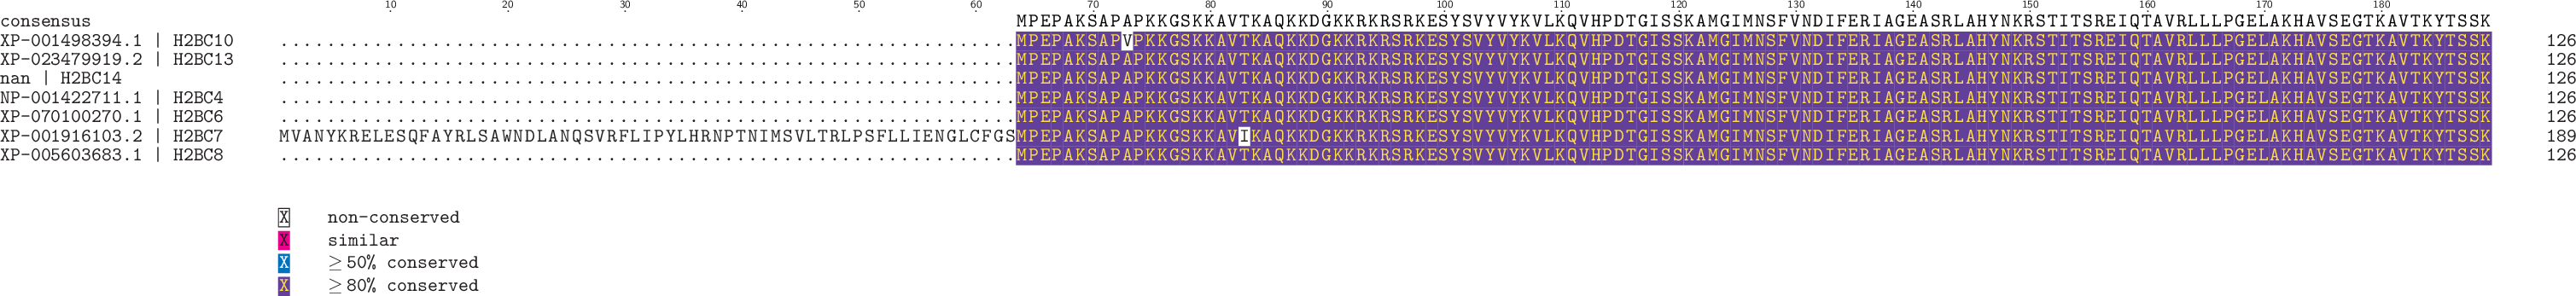

In [68]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC11, 17, 15, 13, 16 Horse

In [69]:
curate_symbols = [f"H2AC{i}" for i in [11, 17, 15, 13, 16]]

In [70]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [71]:
print(sequences)

>XP_023479918.1|H2AC11 H2AC11|XP_023479918.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_001494450.3|H2AC13 H2AC13|XP_001494450.3
MSQSYSLLFAPSRAYKICTSALSFQSILTTAAASLTMSGRGKQGGKARAKAKTRSSRAGL
QFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHL
QLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKKTESHHKAK

>XP_070100451.1|H2AC15 H2AC15|XP_070100451.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_070100450.1|H2AC16 H2AC16|XP_070100450.1
MTPTCLCCSTMSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPV
YLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLP
NIQAVLLPKKTESHHKAKGKTSFITRTTSVGKTFGCRSHCRIFFPPSLRDHERSLHSVWT
A

>XP_014589773.1|H2AC17 H2AC17|XP_014589773.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK



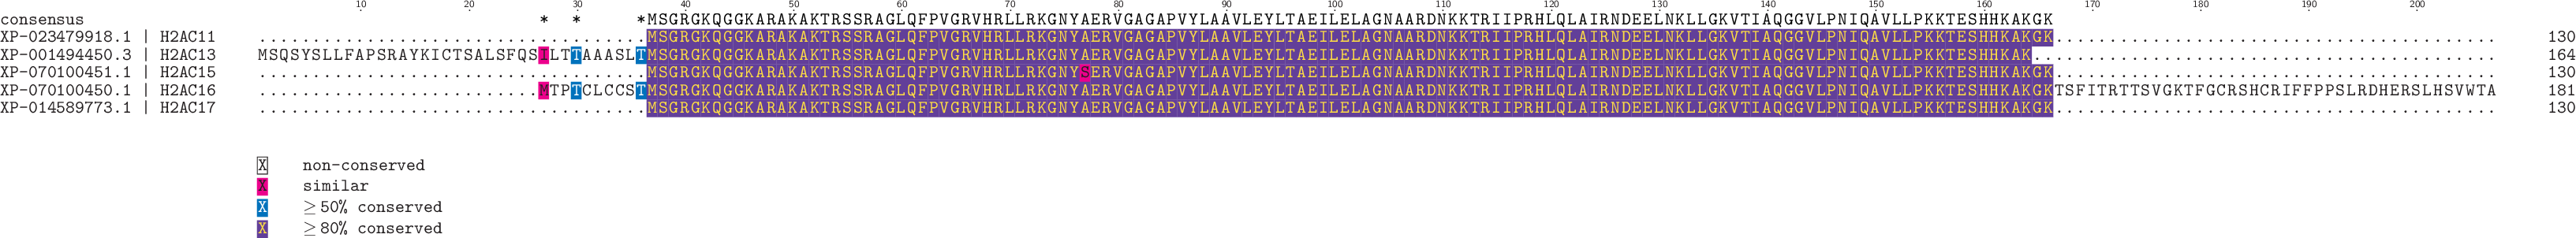

In [72]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC8 & H2AC4 Horse

In [73]:
curate_symbols = [f"H2AC{i}" for i in [8, 4]]

In [74]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [75]:
print(sequences)

>XP_001496794.1|H2AC4 H2AC4|XP_001496794.1
MSGRGKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKK
TESHHKVKGK

>XP_014589726.1|H2AC8 H2AC8|XP_014589726.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK



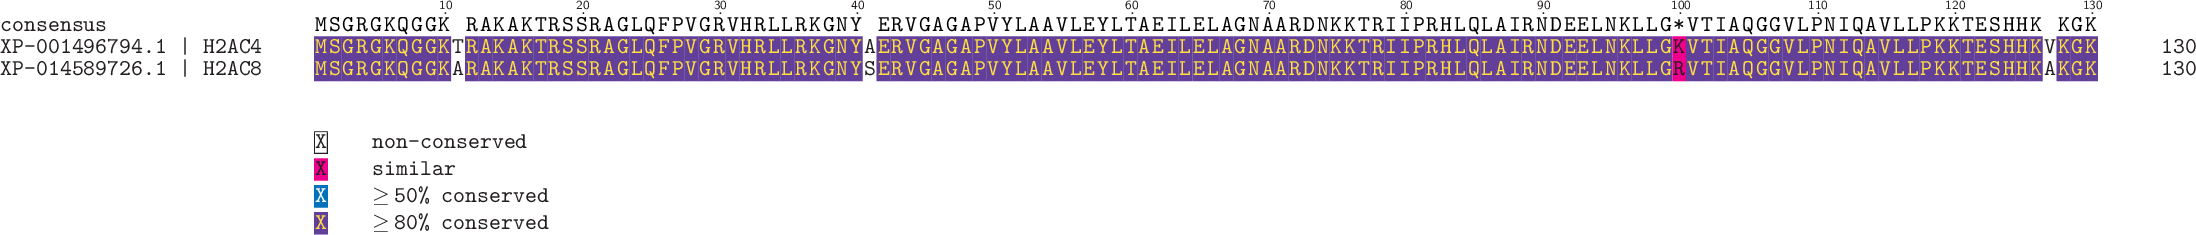

In [76]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H4C2, 15, 9 Horse

In [77]:
curate_symbols = [f"H4C{i}" for i in [2, 15, 9]]

In [78]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [79]:
print(sequences)

>XP_014595304.3|H4C15 H4C15|XP_014595304.3
MTTHRAGGDNLQCFPPARFGFSIWSDALAYEERRRPRRSQRSCLRPAAVMSGRGKGGKGL
GKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAV
TYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG

>nan|H4C2 H4C2|nan
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGGQ

>XP_023479923.1|H4C9 H4C9|XP_023479923.1
MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLK
VFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG



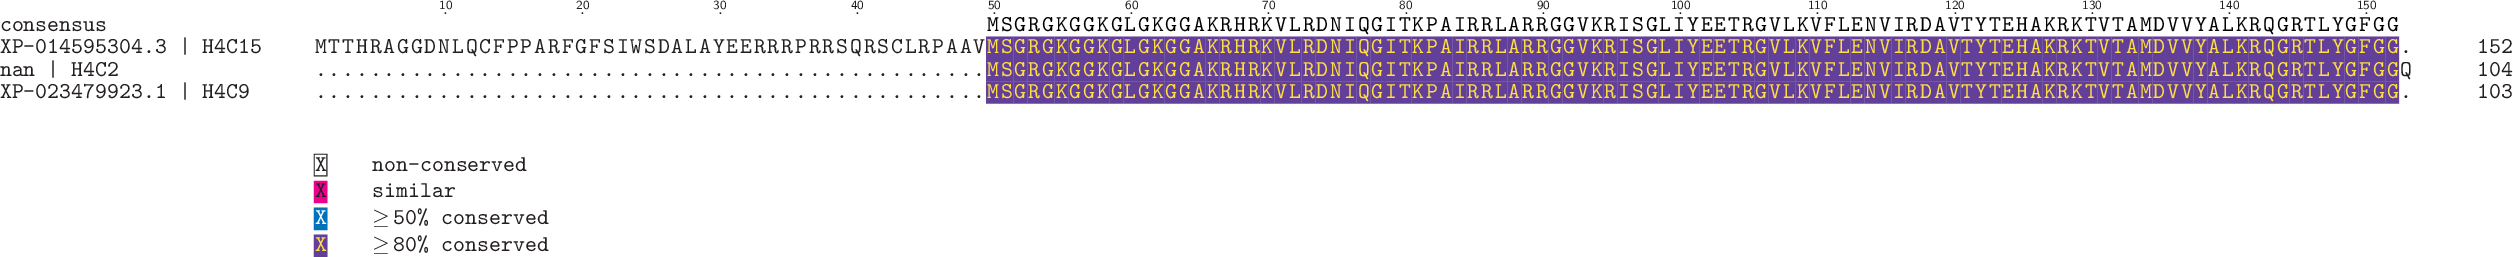

In [80]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C5, 1, 4 Horse

In [81]:
curate_symbols = [f"H3C{i}" for i in [5, 1, 4]]

In [82]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [83]:
print(sequences)

>XP_014589724.1|H3C1 H3C1|XP_014589724.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_023480317.1|H3C4 H3C4|XP_023480317.1
MLSFFCQITGLGKFVMARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG
TVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLF
EDTNLCAIHAKRVTIMPKDIQLARRIRGERA

>XP_023480285.2|H3C5 H3C5|XP_023480285.2
IRSEPGRYYSPASFFFCVVVVARSKQAARKSTSGKAPRKQLATKAARKSAPATGGVKKPH
RYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAY
LVGLFEDTNLCAIHAKRVTIMPKDVQLACRIRAERA



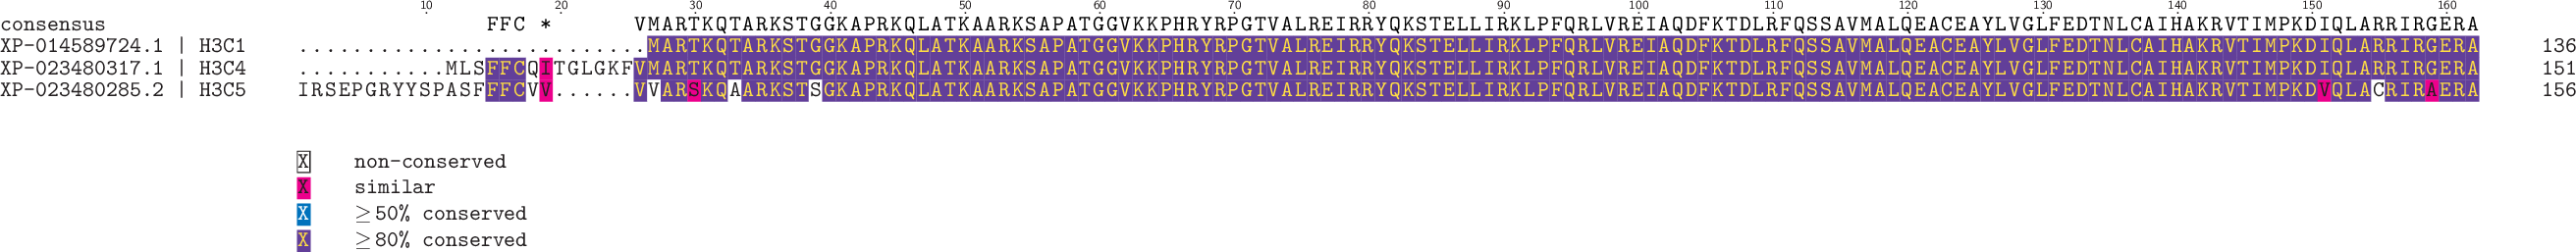

In [84]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C14 & H3C15 Horse

In [89]:
curate_symbols = [f"H3C{i}" for i in [13, 14, 15]]

In [90]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [91]:
print(sequences)

>nan|H3C13 H3C13|nan
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>nan|H3C14 H3C14|nan
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_023497052.2|H3C15 H3C15|XP_023497052.2
MWVISGFTRQQADTSHPLLLLKAPAGLGGAGLGARTDSEAAVAIWALNGPFPARGRRGRL
TVLGEGGSPTFDPCLDSLPRLGSFSPRLLQTCGESVFGYLEDSPLATAPRKDRPGARSSG
SWEEQSNRQNMVLLWNDEAPRSEEIVRVGGPRGDSRAAREVEGQGLLVVRAVGRGFAERV
SAELRCKGCTGLR



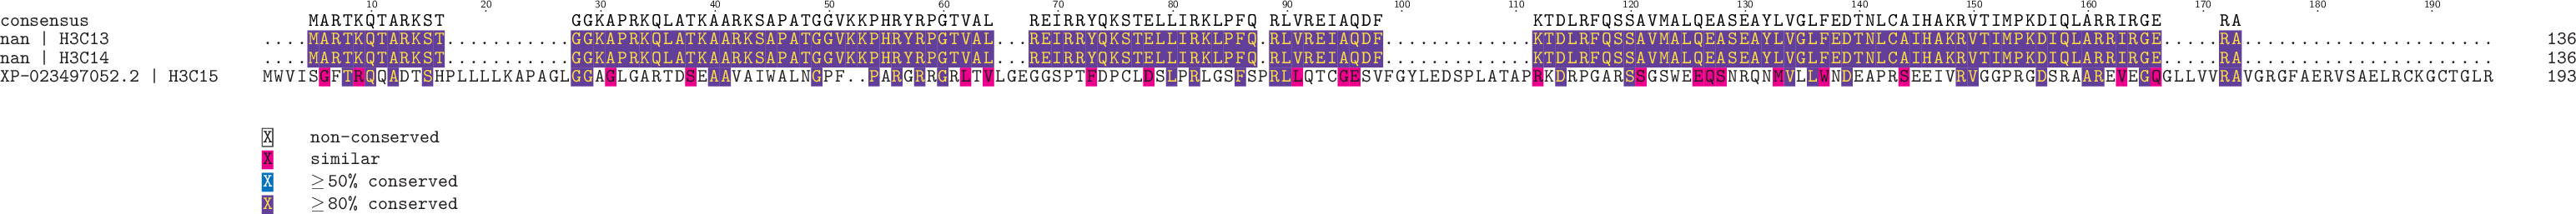

In [92]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC13, 15, 16, 17 Cat

In [97]:
curate_symbols = [f"H2AC{i}" for i in [13, 15, 16, 17]]

In [98]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [99]:
print(sequences)

>XP_003985742.2|H2AC13 H2AC13|XP_003985742.2
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAK

>XP_023110466.1|H2AC15 H2AC15|XP_023110466.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKTKGK

>XP_011280368.1|H2AC16 H2AC16|XP_011280368.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_011280365.1|H2AC17 H2AC17|XP_011280365.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK



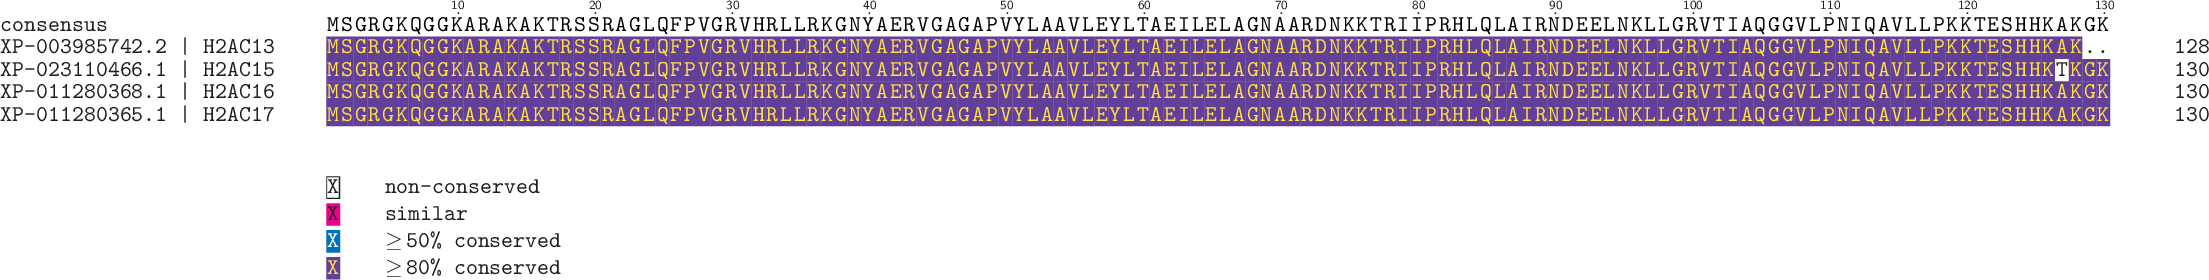

In [100]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H2AC8 & H2AC4 Cat

In [101]:
curate_symbols = [f"H2AC{i}" for i in [4, 8]]

In [102]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [103]:
print(sequences)

>XP_044914448.1|H2AC4 H2AC4|XP_044914448.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK

>XP_011280380.1|H2AC8 H2AC8|XP_011280380.1
MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLT
AEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKK
TESHHKAKGK



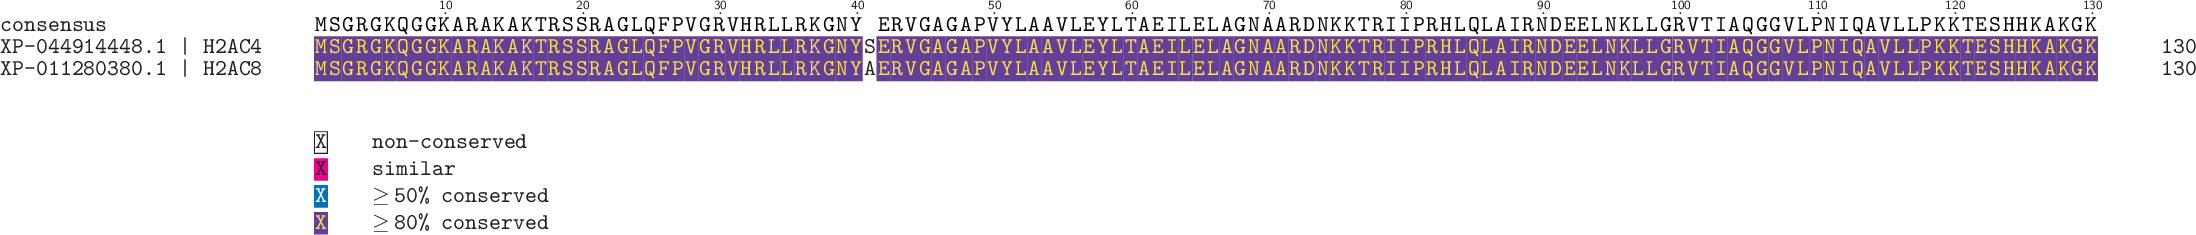

In [104]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C2, 1, 4, 12 Cat

In [105]:
curate_symbols = [f"H3C{i}" for i in [2, 1, 4, 12]]

In [106]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [107]:
print(sequences)

>nan|H3C1 H3C1|nan
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_044914393.1|H3C12 H3C12|XP_044914393.1
MRTADPPKPKTPSAPLYPVLPNSQDLLSLDPPPYHPPPLVPQALPAAAALLVAPLGEPGR
REAAAAPESGGREAIAAPGPIENETDREGPAGRTRGRTQHEPNPRLPDSTVALPLRETGP
PDETGNPRLQYWPFSTSDLYNWKTQNARFSDNPKDLIALLDSVMFTHQPTWDDCQQLLRI
LFTTEERERIQLEKRKLVPGDDGQPTSNPDLINAAFFLTRPPQDEWDYNTAEALQRVHED
VWPKLKELYETGPPPIPHQFHPGDWVLVKRHRQGTLEPRWKGPFQVILTTPTAIKVDGIA
TWIRCTHAKPVDPFSDLIGPSKTTWTVVRTKDNPLKLTLRRQRTEP

>XP_011280366.1|H3C12 H3C12|XP_011280366.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>nan|H3C2 H3C2|nan
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSGQPSTKHKIHLELCGLLGLLYIPGF

>XP_003985814.2|H3C4 H3C4|XP_003985814.2
MPFRTAGTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQ
KSTELLIRKLPFQRLVREIAQDFKTD

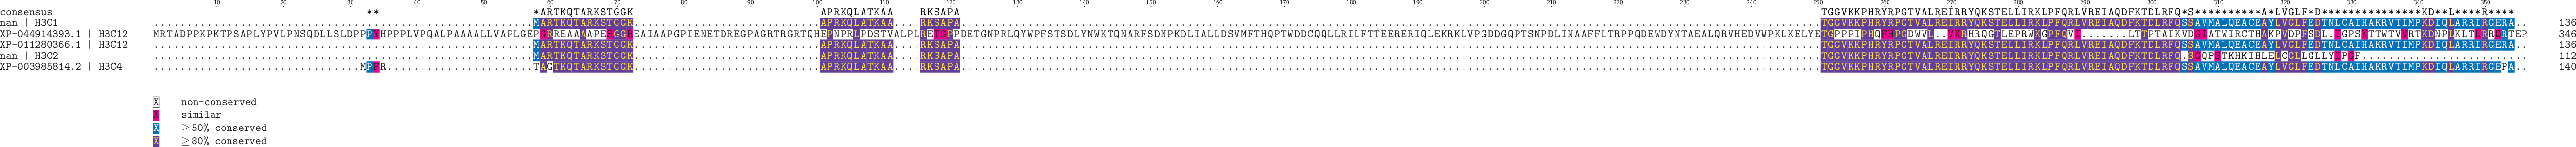

In [108]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C2, 1, 4, 12 Cat after removing XP_044914393.1

In [110]:
curate_symbols = [f"H3C{i}" for i in [2, 1, 4, 12]]

In [111]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [112]:
print(sequences)

>nan|H3C1 H3C1|nan
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_011280366.1|H3C12 H3C12|XP_011280366.1
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>nan|H3C2 H3C2|nan
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSGQPSTKHKIHLELCGLLGLLYIPGF

>XP_003985814.2|H3C4 H3C4|XP_003985814.2
MPFRTAGTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQ
KSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEACEAYLVGLFEDTNLCAIHAK
RVTIMPKDIQLARRIRGEPA



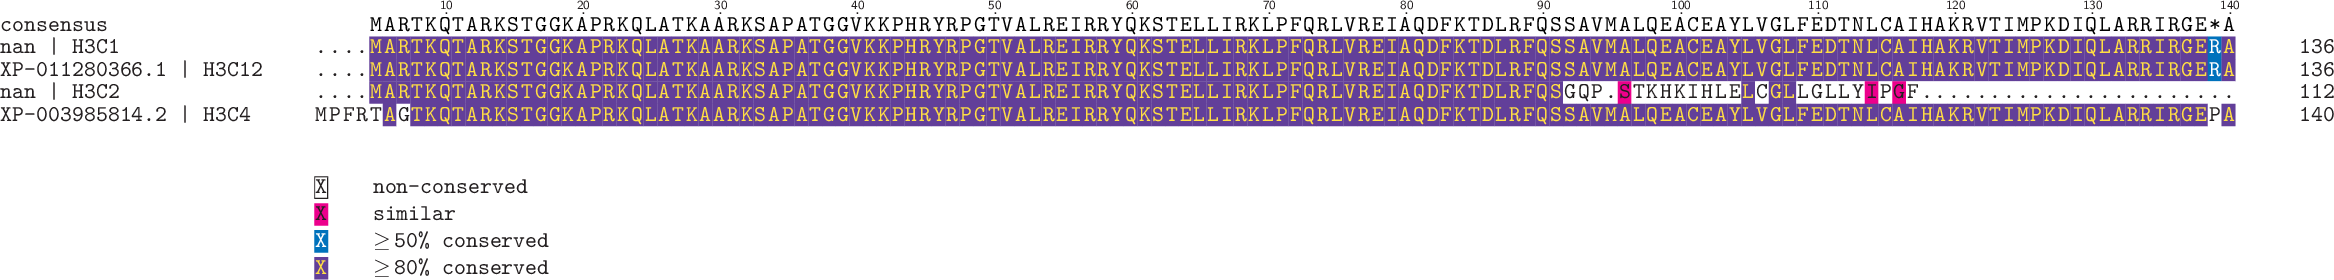

In [113]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

# H3C13 & H3C15 Cat

In [114]:
curate_symbols = [f"H3C{i}" for i in [13, 15]]

In [115]:
sequences = "\n".join(
    [
        SeqRecord(
            Seq(row["sequence"]),
            id=f"{row['accession']}|{row['symbol']}",
            name=str(row["accession"]),
            description=f"{row['symbol'].split()[0]}|{row['accession']}",
        ).format("fasta")
        for i, row in df[df["symbol"].isin(curate_symbols)].iterrows()
    ]
)
msa = muscle_aln(sequences)

In [116]:
print(sequences)

>nan|H3C13 H3C13|nan
MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTE
LLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTI
MPKDIQLARRIRGERA

>XP_023114870.1|H3C15 H3C15|XP_023114870.1
MPGRVTSQPMDSQRGTFNYRPARSEEDGAYKECGGGPRPRYSRCRCAGELVFWFAMARTK
QTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRK
LPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVGLFEDTNLCAIHAKRVTIMPKDI
QLARRIRGERA



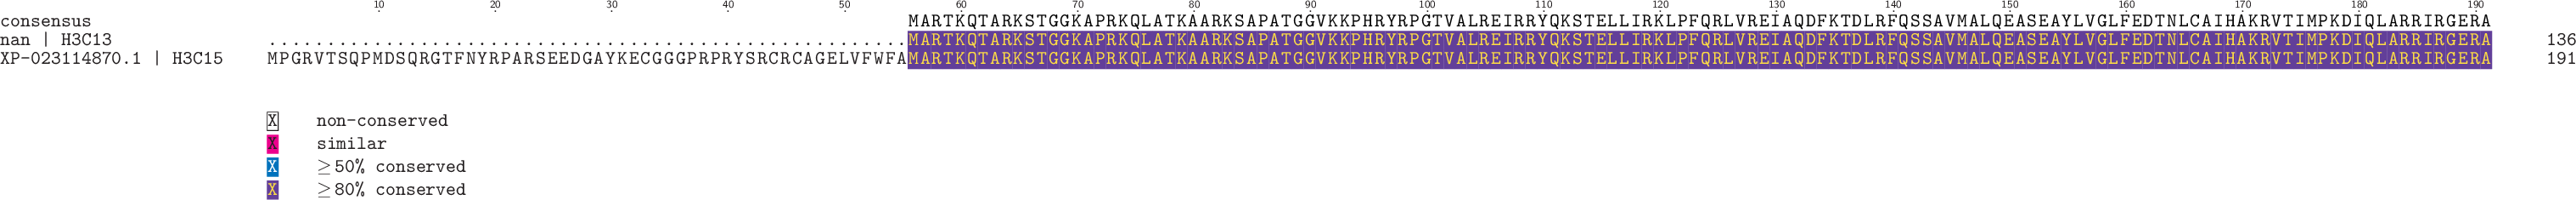

In [117]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)

In [9]:
sequences = """>HISTDB_H2A_Q_4 H2A.Q_Eutheria_Pan_paniscus
MFWKRRQRSSYRCRNQTFSYSIRAKQQFLLSCVHCLLWKNHCPRPELVHYFQILGGNILELMGNKVHKNY
RMHITPKYVERVVDNNPLLSHLFEGDTNSG

>XP_054962204.1 histone H2A-like 3, partial [Pan paniscus]
MAGNKHSRSSCKPRRQCPSRSRRAELQFPVSHMERCLREGQYARHLSSTTPVFLAAVLEYLTANILEQAG
KEAQNSHRVCITPEHLKRALQKNEQLRWILEEEDDIHSQEEEMPQPEEEEEEDERME"""

msa = muscle_aln(sequences)

In [10]:
print(sequences)

>HISTDB_H2A_Q_4 H2A.Q_Eutheria_Pan_paniscus
MFWKRRQRSSYRCRNQTFSYSIRAKQQFLLSCVHCLLWKNHCPRPELVHYFQILGGNILELMGNKVHKNY
RMHITPKYVERVVDNNPLLSHLFEGDTNSG

>XP_054962204.1 histone H2A-like 3, partial [Pan paniscus]
MAGNKHSRSSCKPRRQCPSRSRRAELQFPVSHMERCLREGQYARHLSSTTPVFLAAVLEYLTANILEQAG
KEAQNSHRVCITPEHLKRALQKNEQLRWILEEEDDIHSQEEEMPQPEEEEEEDERME


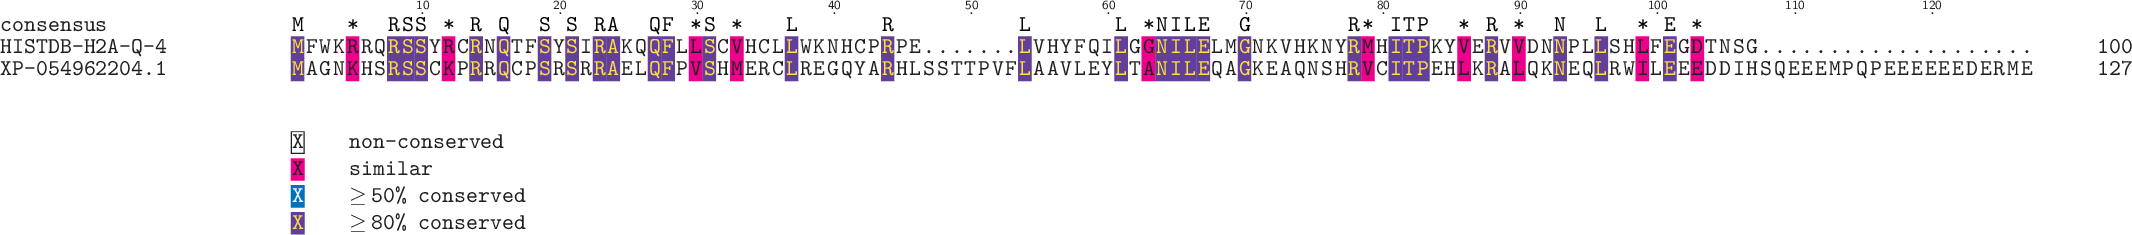

In [11]:
#'similar','charge_functional', 'structure_functional', 'chemical_functional', 'hydropathy_functional'
ipyshade.shadedmsa(
    msa,
    shading_modes=["similar"],
    ruler=True,
    # logo=True,
)